In [4]:
!pip install Sastrawi

In [5]:
# import libraries yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import warnings
warnings.filterwarnings('ignore')

# library buat text preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# library buat machine learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# download data dari NLTK buat teknisasi NLP
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    pass

print("All libraries imported successfully!")

All libraries imported successfully!


In [6]:
# function buat load data review
def load_review_data():
    """Load review data from available CSV files"""
    reviews_data = []

    # Cari file CSV di direktori root
    import os
    import glob

    # Cari file CSV yang mengandung 'review' dalam nama file
    review_files = glob.glob('reviews_*.csv')

    # Jika tidak ada file yang ditemukan, coba cari file dengan 'Review' (making sure, terutama jika tiba-tiba nama file berubah)
    if not review_files:
        review_files = glob.glob('*review*.csv') + glob.glob('*Review*.csv')
        # Hapus duplikasi file yang terbaca (jika ada)
        review_files = list(set(review_files))

    # Fallback: jika tidak ada file yang ditemukan, gunakan semua file tipe CSV di direktori
    if not review_files:
        all_csv_files = glob.glob('*.csv')
        if all_csv_files:
            print("No files with 'review' in the name found. Available CSV files:")
            for file in all_csv_files:
                print(f"  - {file}")
            print("\nUsing all CSV files found:")
            review_files = all_csv_files
        else:
            print("No CSV files found in the current directory.")
            return reviews_data

    print(f"Found {len(review_files)} CSV file(s) to process:")
    for file in review_files:
        print(f"  - {file}")
    print()

    for file in review_files:
        try:
            # Baca file CSV temuan
            df_temp = pd.read_csv(file, encoding='utf-8')

            # Ekstrak nama produk dari nama file (ini bisa maksimalkan proses ekstraksi)
            product_name = file.replace('.csv', '')
            if product_name.startswith('reviews_'):
                product_name = product_name[8:] # => Hapus prefix 'reviews_'

            # Bersihkan nama produk (hapus timestamp dan underscores)
            import re
            # Hapus pola timestamp (YYYYMMDD_HHMMSS)
            product_name = re.sub(r'_\d{8}_\d{6}$', '', product_name)
            # Ganti underscores dengan spasi
            product_name = product_name.replace('_', ' ')

            # Filtering: hanya teks yang benar-benar teks ulasan
            # Skip jika ada kolom yang (sepertinya) dari metadata atau memang tidak relevan
            if 'review' in df_temp.columns:
                # Ini hapus row yang terlalu pendek atau punya pola yang seperti auto-generated.
                df_temp = df_temp[df_temp['review'].notna()]
                df_temp = df_temp[df_temp['review'].str.len() > 10] # => Review minimal 10 karakter (kalo kepanjangan, masih gagal terfilter)
                df_temp = df_temp[~df_temp['review'].str.contains('Key Benefits|Users have reported', na=False)]

            # Convert DataFrame to list of dictionaries
            # Ubah dari DataFrame ke list of dicts (supaya ringan)
            for _, row in df_temp.iterrows():
                review_dict = row.to_dict()
                review_dict['product'] = product_name
                reviews_data.append(review_dict)

            print(f"Loaded {len(df_temp)} reviews from '{product_name}'")
            print(f"Columns in {file}: {df_temp.columns.tolist()}")

        except FileNotFoundError:
            print(f"File {file} not found")
        except Exception as e:
            print(f"Error loading {file}: {e}")
            print(f"Invalid encoding or file format.")

    return reviews_data

# Load data
reviews_data = load_review_data()
print(f"\nTotal reviews loaded: {len(reviews_data)}")

if reviews_data:
    # Convert ke DataFrame untuk analisis lebih lanjut
    df = pd.DataFrame(reviews_data)
    print(f"DataFrame shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Tampilkan informasi dasar data
    if 'review' in df.columns:
        print(f"\nReview text statistics:")
        print(f"- Average review length: {df['review'].str.len().mean():.1f} characters")
        print(f"- Min review length: {df['review'].str.len().min()} characters")
        print(f"- Max review length: {df['review'].str.len().max()} characters")

    # Tampilkan beberapa baris pertama dari DataFrame (validation matters!)
    print(f"\nFirst few rows:")
    display(df.head(3))

    # Tampilkan tipe data masing-masing kolom
    print(f"\nData types:")
    print(df.dtypes)
else:
    print("No data loaded. Please check your CSV files.")
    df = pd.DataFrame()  # => Fallback: buat DataFrame kosong jika tidak ada data

Found 2 CSV file(s) to process:
  - reviews_MSH Niacinamide Brightening Moisture Gel_20250703_191020.csv
  - reviews_Skintific 5X Ceramide Barrier Repair Moisture Gel Moisturizer_20250702_231421.csv

Loaded 1144 reviews from 'MSH Niacinamide Brightening Moisture Gel'
Columns in reviews_MSH Niacinamide Brightening Moisture Gel_20250703_191020.csv: ['review', 'page', 'scraped_at']
Loaded 1527 reviews from 'Skintific 5X Ceramide Barrier Repair Moisture Gel Moisturizer'
Columns in reviews_Skintific 5X Ceramide Barrier Repair Moisture Gel Moisturizer_20250702_231421.csv: ['review', 'page', 'scraped_at']

Total reviews loaded: 2671
DataFrame shape: (2671, 4)
Columns: ['review', 'page', 'scraped_at', 'product']

Review text statistics:
- Average review length: 252.6 characters
- Min review length: 11 characters
- Max review length: 1110 characters

First few rows:


,review,page,scraped_at,product
0,Moisturizer ini benar-benar jadi holy grail bu...,1,2025-07-03T19:04:50.899164,MSH Niacinamide Brightening Moisture Gel
1,"awalnya sih bagus bagus aja, tapi entah kenapa...",1,2025-07-03T19:04:50.899222,MSH Niacinamide Brightening Moisture Gel
2,Dibandingkan dengan moisturizer yang warna bir...,1,2025-07-03T19:04:50.899246,MSH Niacinamide Brightening Moisture Gel



Data types:
review        object
page           int64
scraped_at    object
product       object
dtype: object


In [7]:
# Text Preprocessing Class
class IndonesianTextPreprocessor:
    def __init__(self):
        # Inisiasi stemmer dan stopword remover untuk Bahasa Indonesia
        factory = StemmerFactory()
        self.stemmer = factory.create_stemmer()

        stop_factory = StopWordRemoverFactory()
        self.stopword_remover = stop_factory.create_stop_word_remover()

        # Additional Indonesian stopwords
        self.additional_stopwords = {
            'yang', 'ini', 'itu', 'dengan', 'untuk', 'dari', 'ke', 'di', 'pada', 'oleh',
            'saya', 'aku', 'kamu', 'dia', 'mereka', 'kita', 'kalian',
            'sangat', 'sekali', 'banget', 'bgt', 'sih', 'deh', 'dong', 'loh', 'kok',
            'produk', 'skincare', 'wajah', 'kulit', 'moisturizer', 'gel'
        }

    def clean_text(self, text):
        """Clean and normalize text"""
        if pd.isna(text) or text == '':
            return ''

        # Convert kata ke lowercase
        text = str(text).lower()

        # Hapus URL (jika ada)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Hapus email address (jika ada)
        text = re.sub(r'\S+@\S+', '', text)

        # Hapus angka dan karakter khusus (kaya emoticon atau puctuations), sisakan kata dan spasi
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # hapus whitespace yang berlebih
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_text(self, text):
        """Tokenize text into words"""
        if not text:
            return []

        # Tokenisasi sederhana (dipisahin dari spasi)
        tokens = text.split()

        # filter token yang kependekan
        tokens = [token for token in tokens if len(token) >= 4 and len(token) <= 25]

        return tokens

    def remove_stopwords(self, tokens):
        """Remove stopwords from tokens"""
        # Gabungkan token menjadi string untuk stopword removal dengan Sastrawi
        text = ' '.join(tokens)
        text = self.stopword_remover.remove(text)

        # Pisahkan lagi token dan hapus stopwords tambahan
        # (Sastrawi sudah menghapus stopwords umum, tapi kita tambahkan yang spesifik)
        # (Misalnya: 'produk', 'skincare', 'wajah', dll
        tokens = text.split()
        tokens = [token for token in tokens if token not in self.additional_stopwords]

        return tokens

    def stem_tokens(self, tokens):
        """Apply stemming to tokens"""
        # Gabungkan token untuk proses stemming
        text = ' '.join(tokens)
        stemmed_text = self.stemmer.stem(text)

        return stemmed_text.split()

    def preprocess(self, text, include_stemming=True):
        """Complete preprocessing pipeline"""
        # bersihkan teks
        cleaned_text = self.clean_text(text)

        # tokenisasi
        tokens = self.tokenize_text(cleaned_text)

        # hapus stopwords
        tokens = self.remove_stopwords(tokens)

        # lakukan stemming - optional (default selalu true)
        if include_stemming:
            tokens = self.stem_tokens(tokens)

        # kembalikan ke string
        processed_text = ' '.join(tokens)

        return processed_text

# Inisiasi preprocessor
preprocessor = IndonesianTextPreprocessor()

# Lakukan preprocessing pada contoh review
if len(df) > 0:
    sample_text = df['review'].iloc[0] if 'review' in df.columns else str(df.iloc[0, 0])
    print("Original text:")
    print(sample_text)
    print("\nProcessed text:")
    print(preprocessor.preprocess(sample_text))
else:
    print("No data available for testing")

Original text:
Moisturizer ini benar-benar jadi holy grail buat aku yang cari pelembap ringan tapi ada plus-nya! Teksturnya nyaman banget di kulit, nggak bikin berat sama sekali dan cepat meresap sempurna. Setiap kali pakai, kulit langsung terasa lembab tanpa ada rasa lengket atau greasy. Yang paling aku suka, moisturizer ini juga kasih efek mencerahkan sedikit di wajah. Nggak instan yang bikin putih banget, tapi perlahan kulitku jadi kelihatan lebih cerah dan merata warnanya.

Processed text:
benar benar jadi holy grail buat cari lembap ringan plus tekstur nyaman bikin berat sama cepat resap sempurna kali pakai langsung asa lembab rasa lengket greasy paling suka kasih efek cerah sedikit instan bikin putih perlahan kulit jadi lihat lebih cerah rata warna


In [8]:
class AdvancedIndonesianSentimentLabeler:
    def __init__(self):
        # === SENTIMEN KATA UNIGRAM ===
        # Bank kata positif dengan skor intensitas (1.0 = normal, 2.0 = sangat positif)
        self.positive_words = {
            # Kata positif umum
            'bagus': 1.0, 'baik': 1.0, 'suka': 1.0, 'senang': 1.0, 'puas': 1.5, 'mantap': 1.5,
            'keren': 1.0, 'oke': 0.8, 'cocok': 1.2, 'recommended': 1.5, 'recommend': 1.5,

            # Kata positif intensif (English)
            'love': 2.0, 'amazing': 2.0, 'perfect': 2.0, 'excellent': 2.0, 'good': 1.0,
            'great': 1.5, 'awesome': 2.0, 'fantastic': 2.0, 'wonderful': 2.0,

            # Kata positif untuk skincare/moisturizer
            'lembut': 1.2, 'halus': 1.2, 'wangi': 1.0, 'fresh': 1.2, 'nyaman': 1.2,
            'mudah': 1.0, 'cepat': 1.0, 'efektif': 1.5, 'moisturizing': 1.5, 'hydrating': 1.5,
            'melembabkan': 1.5, 'mencerahkan': 1.5, 'melembutkan': 1.2,

            # Kata positif berkaitan dengan harga
            'terjangkau': 1.0, 'murah': 1.0, 'worth': 1.2, 'worthed': 1.2,
            'satisfied': 1.5, 'worthy': 1.2,

            # Kata intensitas tinggi (Indonesian slang)
            'banget': 1.5, 'bgt': 1.5, 'sekali': 1.3, 'poll': 2.0, 'parah': 1.8
        }

        # Bank kata negatif dengan skor intensitas
        self.negative_words = {
            # Kata negatif umum
            'jelek': 1.0, 'buruk': 1.5, 'benci': 2.0, 'kecewa': 1.5, 'zonk': 1.8,
            'mengecewakan': 1.5, 'gagal': 1.5, 'fail': 1.5,

            # Kata negatif intensif (English)
            'disappointed': 1.5, 'bad': 1.0, 'terrible': 2.0, 'awful': 2.0, 'worst': 2.0,
            'hate': 2.0, 'horrible': 2.0, 'disgusting': 2.0,

            # Kata yang bermakna 'masalah'
            'problem': 1.2, 'masalah': 1.2, 'error': 1.5, 'trouble': 1.2,

            # Kata negatif spesifik skincare
            'breakout': 1.5, 'iritasi': 1.5, 'gatal': 1.2, 'perih': 1.3, 'panas': 1.0,
            'berminyak': 1.0, 'lengket': 1.0, 'berat': 0.8, 'sulit': 1.0, 'susah': 1.0,
            'bruntusan': 1.5, 'jerawat': 1.2, 'minyak': 1.5,

            # Kata negatif berkaitan dengan harga
            'mahal': 1.0, 'expensive': 1.0, 'overpriced': 1.5, 'kemahalan': 1.2
        }

        # === POLA SENTIMEN BIGRAM/TRIGRAM ===
        # Pola n-gram positif (frasa yang menunjukkan sentimen positif)
        self.positive_ngrams = {
            # Bigrams
            'sangat bagus': 2.0, 'sangat baik': 2.0, 'sangat cocok': 2.0, 'sangat puas': 2.5,
            'sangat suka': 2.0, 'benar benar': 1.5, 'bener bener': 1.5, 'worth hype': 2.0,
            'highly recommended': 2.5, 'very good': 2.0, 'so good': 2.0, 'really good': 2.0,
            'cepat meresap': 1.5, 'mudah meresap': 1.5, 'tidak lengket': 1.2, 'ringan banget': 1.5,
            'cocok banget': 2.0, 'bagus banget': 2.0, 'love banget': 2.5, 'suka banget': 2.0, 'holy grail': 2.5,

            # Trigrams
            'sangat sangat bagus': 2.5, 'benar benar bagus': 2.0, 'worth the hype': 2.0,
            'sangat cocok banget': 2.5, 'bagus banget sih': 2.0, 'recommended banget deh': 2.5
        }

        # Pola n-gram negatif
        self.negative_ngrams = {
            # Bigrams
            'sangat buruk': 2.0, 'sangat jelek': 2.0, 'sangat kecewa': 2.5, 'very bad': 2.0,
            'so bad': 2.0, 'really bad': 2.0, 'tidak cocok': 1.5, 'gak cocok': 1.5,
            'bikin bruntusan': 2.0, 'bikin jerawat': 1.8, 'malah bruntusan': 2.0,
            'jadi bruntusan': 1.8, 'breakout parah': 2.5, 'iritasi parah': 2.5,
            'totally disappointed': 2.5, 'waste money': 2.0, 'buang uang': 2.0, 'bruntusan parah': 2.5,

            # Trigrams
            'sangat sangat buruk': 2.5, 'benar benar kecewa': 2.5, 'totally waste money': 2.5,
            'malah jadi bruntusan': 2.0, 'bikin muka bruntusan': 2.0, 'bruntusan parah banget': 2.5,
        }

        # === HANDLING NEGASI ===
        # Kata-kata negasi yang bisa membalikkan sentimen
        self.negation_words = {
            'tidak', 'nggak', 'gak', 'ga', 'bukan', 'never', 'no', 'nothing',
            'enggak', 'ndak', 'nda', 'kagak', 'kaga', 'tapi'
        }

        # === KATA PENGUAT SENTIMEN ===
        # Kata-kata yang memperkuat sentimen
        self.intensifiers = {
            'sangat': 1.5, 'sekali': 1.3, 'banget': 1.5, 'bgt': 1.5, 'very': 1.5,
            'really': 1.5, 'so': 1.3, 'super': 1.8, 'ultra': 1.8, 'extremely': 2.0,
            'totally': 1.8, 'absolutely': 2.0, 'definitely': 1.5,
            'benar': 1.3, 'bener': 1.3, 'beneran': 1.5, 'emang': 1.2, 'memang': 1.2
        }

        # === KATA PELEMAH SENTIMEN ===
        # Kata-kata yang melemahkan sentimen
        self.diminishers = {
            'agak': 0.7, 'sedikit': 0.7, 'lumayan': 0.8, 'cukup': 0.8, 'quite': 0.8,
            'rather': 0.7, 'somewhat': 0.7, 'biasa': 0.6, 'standar': 0.6,
            'kurang': 0.5, 'less': 0.7, 'little': 0.7
        }

    def extract_ngrams(self, words, n=2):
        """
        Ekstrak n-gram dari list kata
        n=2 untuk bigram, n=3 untuk trigram
        """
        ngrams = []
        for i in range(len(words) - n + 1):
            ngram = ' '.join(words[i:i+n])
            ngrams.append(ngram)
        return ngrams

    def calculate_sentiment_score(self, text):
        """
        Hitung skor sentimen dengan algoritma yang lebih canggih
        Menggunakan unigram, bigram, trigram, dan context analysis
        """
        if not text:
            return 0.0

        words = text.lower().split()
        if len(words) == 0:
            return 0.0

        # === KALKULASI SKOR ===
        positive_score = 0.0
        negative_score = 0.0

        # === 1. ANALISIS N-GRAM ===
        # Analisis bigram dan trigram terlebih dahulu (prioritas tinggi)
        # analisis trigram
        trigrams = self.extract_ngrams(words, 3)
        for trigram in trigrams:
            if trigram in self.positive_ngrams:
                positive_score += self.positive_ngrams[trigram]
            elif trigram in self.negative_ngrams:
                negative_score += self.negative_ngrams[trigram]

        # analisis bigram
        bigrams = self.extract_ngrams(words, 2)
        for bigram in bigrams:
            if bigram in self.positive_ngrams:
                positive_score += self.positive_ngrams[bigram]
            elif bigram in self.negative_ngrams:
                negative_score += self.negative_ngrams[bigram]

        # === 2. ANALISIS UNIGRAM DENGAN KONTEKS ===
        negated = False
        intensifier_multiplier = 1.0
        diminisher_multiplier = 1.0

        for i, word in enumerate(words):
            # reset modifiers setiap beberapa kata untuk mencegah efek jarak jauh
            if i > 0 and i % 4 == 0:
                negated = False
                intensifier_multiplier = 1.0
                diminisher_multiplier = 1.0

            # Cek negasi
            if word in self.negation_words:
                negated = True
                continue

            # Cek kata penguat sentimen (intensifier)
            if word in self.intensifiers:
                intensifier_multiplier = max(intensifier_multiplier, self.intensifiers[word])
                continue

            # Cek kata pelemah sentimen (diminisher)
            if word in self.diminishers:
                diminisher_multiplier = min(diminisher_multiplier, self.diminishers[word])
                continue

            # Hitung skor sentimen untuk kata
            current_score = 0.0

            if word in self.positive_words:
                current_score = self.positive_words[word]
                # implement modifiers
                current_score *= intensifier_multiplier * diminisher_multiplier

                if negated:
                    # Negasi membalik sentimen dan mengurangi intensitas
                    negative_score += current_score * 0.8
                else:
                    positive_score += current_score

            elif word in self.negative_words:
                current_score = self.negative_words[word]
                # implement modifiers
                current_score *= intensifier_multiplier * diminisher_multiplier

                if negated:
                    # Negasi membalik sentimen
                    positive_score += current_score * 0.8
                else:
                    negative_score += current_score

            # Reset negasi setelah proses selesai
            if current_score > 0:
                negated = False

        # === 3. Adjustment berdasarkan konteks ===
        # Adjustment berdasarkan panjang teks
        text_length_factor = min(1.0, len(words) / 10.0)  # => Normalisasi untuk teks pendek

        # === 4. HITUNG SKOR FINAL ===
        # Hitung net sentiment score
        net_score = (positive_score - negative_score) * text_length_factor

        return net_score

    def label_sentiment(self, text, threshold_positive=0.5, threshold_negative=-0.9):
        """
        Label sentiment dengan threshold yang dapat disesuaikan
        Menggunakan scoring yang lebih sophisticated
        """
        sentiment_score = self.calculate_sentiment_score(text)

        # === KLASIFIKASI SENTIMEN ===
        if sentiment_score >= threshold_positive:
            return 'positive'
        elif sentiment_score <= threshold_negative:
            return 'negative'
        else:
            # === KLASIFIKASI NEUTRAL ===
            words = text.lower().split()

            # Cek pola n-gram yang netral
            neutral_indicators = ['ok', 'oke', 'biasa', 'standar', 'cukup', 'lumayan']
            if any(indicator in text.lower() for indicator in neutral_indicators):
                return 'neutral'

            # Anggap teks yang lebih pendek dari 3 karakter (jika ada) sebagai netral
            # supaya tidak mengganggu analisis
            if len(words) < 3:
                return 'neutral'

            # Jika tidak ada kata sentiment yang kuat, klasifikasi sebagai neutral
            return 'neutral'

    def get_sentiment_details(self, text):
        """
        Memberikan detail analisis sentiment untuk debugging dan insight
        """
        sentiment_score = self.calculate_sentiment_score(text)
        sentiment_label = self.label_sentiment(text)

        words = text.lower().split()

        # Analisis komponen
        bigrams = self.extract_ngrams(words, 2)
        trigrams = self.extract_ngrams(words, 3)

        found_positive_words = [word for word in words if word in self.positive_words]
        found_negative_words = [word for word in words if word in self.negative_words]
        found_positive_ngrams = [ng for ng in bigrams + trigrams if ng in self.positive_ngrams]
        found_negative_ngrams = [ng for ng in bigrams + trigrams if ng in self.negative_ngrams]

        return {
            'sentiment': sentiment_label,
            'score': sentiment_score,
            'positive_words': found_positive_words,
            'negative_words': found_negative_words,
            'positive_ngrams': found_positive_ngrams,
            'negative_ngrams': found_negative_ngrams,
            'word_count': len(words)
        }

# Inisiasi labeler sentimen
print("Initialize sentiment labeller...")
sentiment_labeler = AdvancedIndonesianSentimentLabeler()

# Test dengan beberapa contoh untuk memastikan kinerja
print("\n=== TESTING ADVANCED SENTIMENT LABELER ===")
test_examples = [
    "Produk ini sangat bagus banget dan cocok untuk kulit saya",
    "Sangat kecewa dengan produk ini, bikin bruntusan parah",
    "Lumayan sih, tidak terlalu bagus tapi juga tidak buruk",
    "Amazing product! Highly recommended for sensitive skin",
    "Gak cocok di kulit saya, malah jadi bruntusan",
    "Benar benar worth the hype, love banget sama produk ini"
]

for i, example in enumerate(test_examples, 1):
    details = sentiment_labeler.get_sentiment_details(example)
    print(f"\n{i}. '{example}'")
    print(f"   Sentiment: {details['sentiment']} (Score: {details['score']:.2f})")
    if details['positive_words']:
        print(f"   Positive words: {details['positive_words']}")
    if details['negative_words']:
        print(f"   Negative words: {details['negative_words']}")
    if details['positive_ngrams']:
        print(f"   Positive n-grams: {details['positive_ngrams']}")
    if details['negative_ngrams']:
        print(f"   Negative n-grams: {details['negative_ngrams']}")

# Apply advanced preprocessing and sentiment labeling to the dataset
# Aplikasikan preprocessing dan sentiment labeling ke dataset
if len(df) > 0:
    # Ambil kolom ulasan
    text_column = None
    for col in df.columns:
        if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower():
            text_column = col
            break

    if text_column is None:
        # Gunakan kolom string pertama
        for col in df.columns:
            if df[col].dtype == 'object':
                text_column = col
                break

    if text_column:
        print(f"\n=== PROCESSING DATASET ===")
        print(f"Using column '{text_column}' for sentiment analysis")

        # Implementasi preprocessing (sudah ada processed_text dari cell sebelumnya)
        if 'processed_text' not in df.columns:
            print("Applying text preprocessing...")
            df['processed_text'] = df[text_column].apply(lambda x: preprocessor.preprocess(str(x)))

        # Implement sentiment labeling
        print("Applying advanced sentiment labeling...")
        df['sentiment'] = df[text_column].apply(lambda x: sentiment_labeler.label_sentiment(str(x)))
        df['sentiment_score'] = df[text_column].apply(lambda x: sentiment_labeler.calculate_sentiment_score(str(x)))

        # Tampilkan hasil
        print(f"\nDataset shape after processing: {df.shape}")
        print(f"\nSentiment distribution:")
        sentiment_counts = df['sentiment'].value_counts()
        for sentiment, count in sentiment_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {sentiment}: {count} ({percentage:.1f}%)")

        print(f"\nSentiment score statistics:")
        print(df['sentiment_score'].describe())

        # Tampilkan sample data dengan detail analisis
        print(f"\n=== SAMPLE PROCESSED DATA (dengan detail analisis) ===")
        sample_df = df[['product', text_column, 'processed_text', 'sentiment', 'sentiment_score']].head(3)
        for idx, row in sample_df.iterrows():
            print(f"\nProduct: {row['product']}")
            print(f"Original: {row[text_column][:100]}...")
            print(f"Processed: {row['processed_text'][:50]}...")
            print(f"Sentiment: {row['sentiment']} (Score: {row['sentiment_score']:.2f})")

            # Tampilkan detail analisis untuk data pertama
            if idx == sample_df.index[0]:
                details = sentiment_labeler.get_sentiment_details(row[text_column])
                if details['positive_words'] or details['negative_words']:
                    print(f"Detail Analysis:")
                    if details['positive_words']:
                        print(f"  - Positive words found: {details['positive_words']}")
                    if details['negative_words']:
                        print(f"  - Negative words found: {details['negative_words']}")
                    if details['positive_ngrams']:
                        print(f"  - Positive n-grams found: {details['positive_ngrams']}")
                    if details['negative_ngrams']:
                        print(f"  - Negative n-grams found: {details['negative_ngrams']}")
            print("-" * 60)
    else:
        print("No suitable text column found in the dataset")
else:
    print("No data available for processing")

Initialize sentiment labeller...

=== TESTING ADVANCED SENTIMENT LABELER ===

1. 'Produk ini sangat bagus banget dan cocok untuk kulit saya'
   Sentiment: positive (Score: 7.30)
   Positive words: ['bagus', 'banget', 'cocok']
   Positive n-grams: ['sangat bagus', 'bagus banget']

2. 'Sangat kecewa dengan produk ini, bikin bruntusan parah'
   Sentiment: negative (Score: -7.16)
   Positive words: ['parah']
   Negative words: ['kecewa', 'bruntusan']
   Negative n-grams: ['sangat kecewa', 'bikin bruntusan', 'bruntusan parah']

3. 'Lumayan sih, tidak terlalu bagus tapi juga tidak buruk'
   Sentiment: neutral (Score: -0.45)
   Positive words: ['bagus']
   Negative words: ['buruk']

4. 'Amazing product! Highly recommended for sensitive skin'
   Sentiment: positive (Score: 4.20)
   Positive words: ['amazing', 'recommended']
   Positive n-grams: ['highly recommended']

5. 'Gak cocok di kulit saya, malah jadi bruntusan'
   Sentiment: negative (Score: -6.21)
   Positive words: ['cocok']
   Negati

=== ENHANCED SENTIMENT DATA EXPLORATION ===


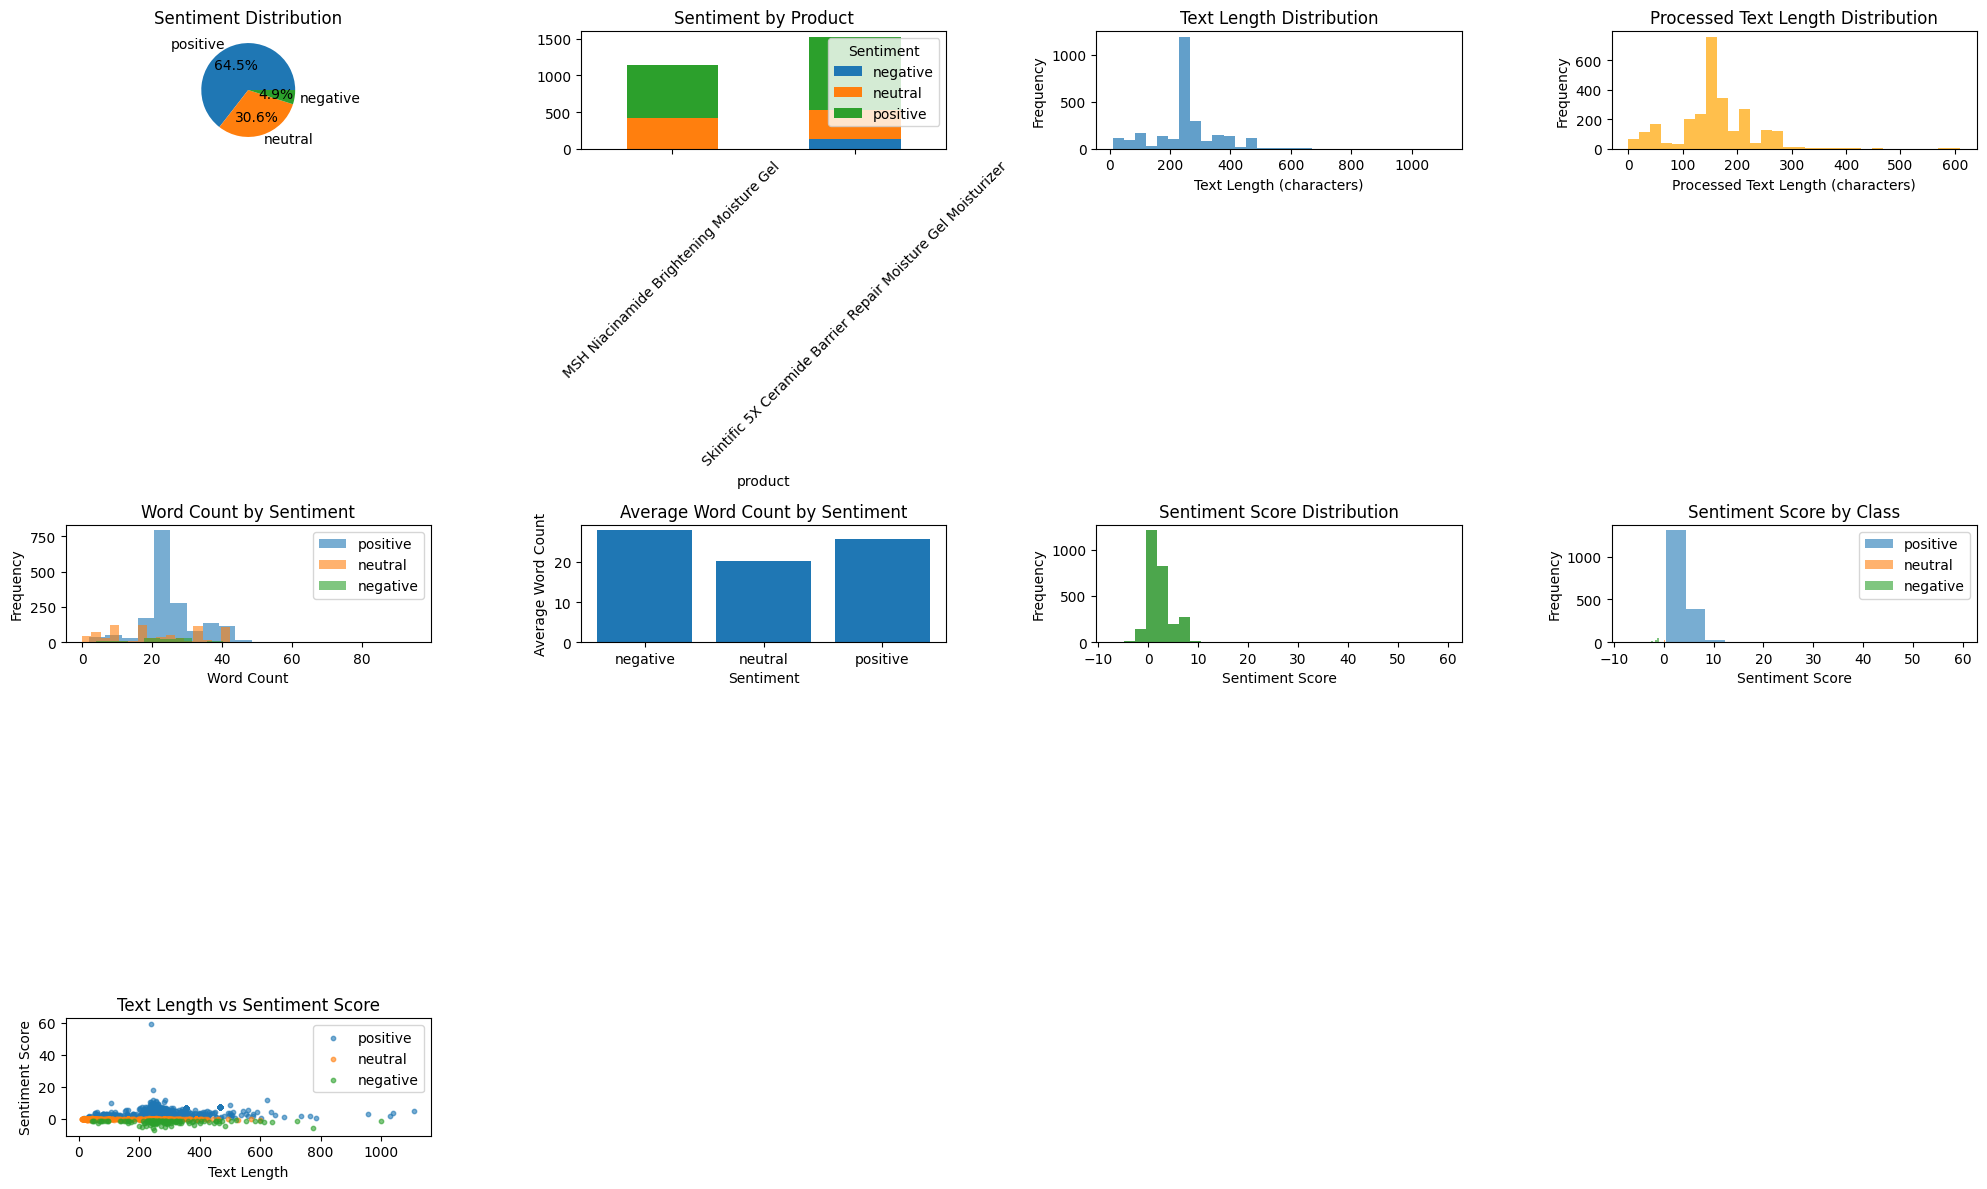


=== DATASET STATISTICS ===
Total reviews: 2671
Unique products: 2

Text length statistics:
count    2671.000000
mean      252.590041
std       110.684090
min        11.000000
25%       233.000000
50%       250.000000
75%       283.000000
max      1110.000000
Name: text_length, dtype: float64

Processed text length statistics:
count    2671.000000
mean      154.974167
std        68.247005
min         0.000000
25%       128.000000
50%       157.000000
75%       190.000000
max       610.000000
Name: processed_length, dtype: float64

Word count statistics:
count    2671.000000
mean       24.092849
std        10.883361
min         0.000000
25%        19.000000
50%        24.000000
75%        29.000000
max        95.000000
Name: word_count, dtype: float64

Sentiment distribution:
positive: 1722 (64.5%)
neutral: 818 (30.6%)
negative: 131 (4.9%)
=== GENERATING WORD CLOUDS ===


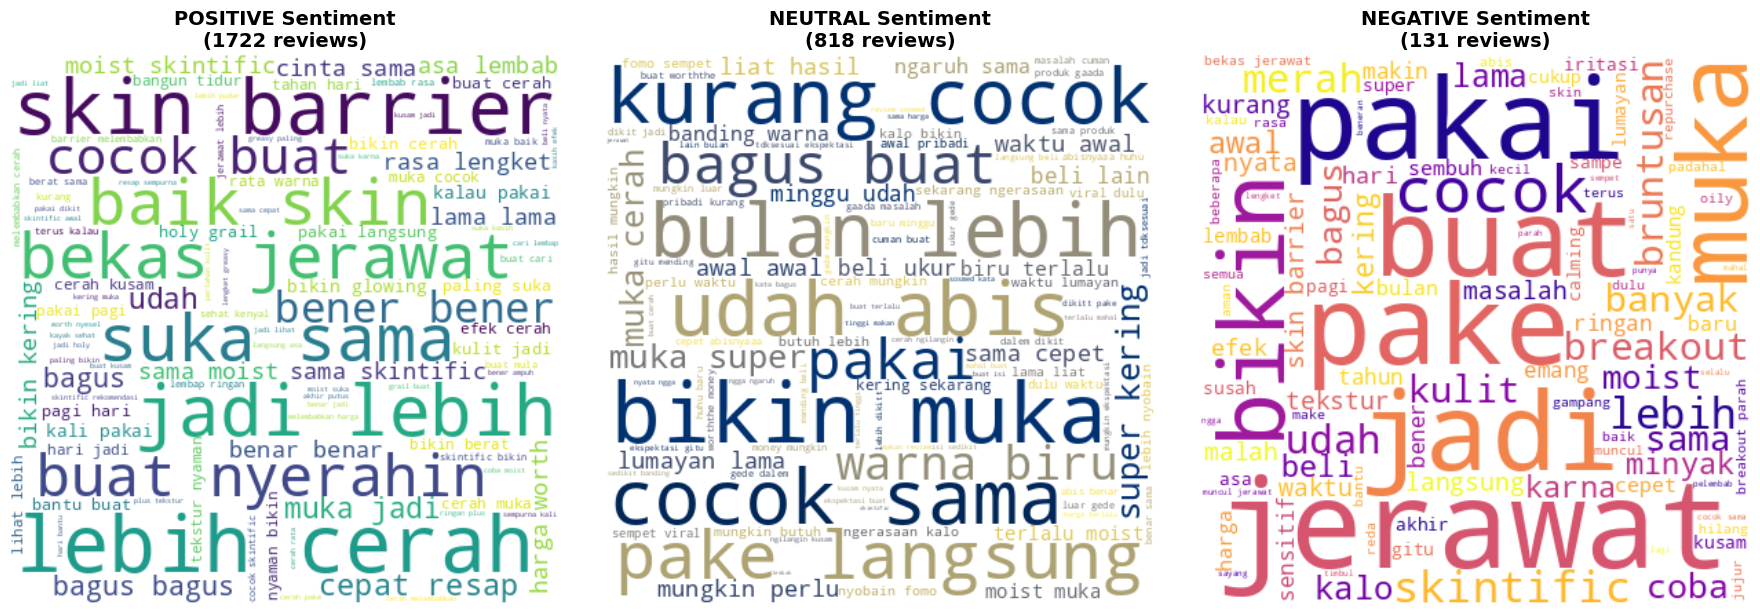

=== GENERATING INTERACTIVE SCATTER PLOTS ===


In [9]:
# Explorasi dan visualisasi data (word cloud + scatter plots)
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

def create_wordclouds(df):
    """Create word clouds for each sentiment class"""
    print("=== GENERATING WORD CLOUDS ===")

    # Cek kolom yang diperlukan
    if 'processed_text' not in df.columns or 'sentiment' not in df.columns:
        print("Processed text or sentiment columns not found. Skipping word clouds.")
        return

    sentiments = df['sentiment'].unique()
    n_sentiments = len(sentiments)

    fig, axes = plt.subplots(1, n_sentiments, figsize=(6*n_sentiments, 6))
    if n_sentiments == 1:
        axes = [axes]

    for i, sentiment in enumerate(sentiments):
        # Dapatkan semua teks untuk sentimen ini
        sentiment_texts = df[df['sentiment'] == sentiment]['processed_text']
        all_text = ' '.join(sentiment_texts.dropna().astype(str))

        if len(all_text.strip()) > 0:
            # Generate word cloud
            wordcloud = WordCloud(
                width=400,
                height=400,
                background_color='white',
                max_words=100,
                colormap='viridis' if sentiment == 'positive' else ('plasma' if sentiment == 'negative' else 'cividis'),
                relative_scaling=0.5,
                random_state=42
            ).generate(all_text)

            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{sentiment.upper()} Sentiment\n({len(sentiment_texts)} reviews)',
                            fontsize=14, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'No data\nfor {sentiment}',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{sentiment.upper()} Sentiment', fontsize=14)
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def create_interactive_scatter_plots(df):
    """Create interactive scatter plots for sentiment analysis"""
    print("=== GENERATING INTERACTIVE SCATTER PLOTS ===")

    if 'processed_text' not in df.columns or 'sentiment' not in df.columns:
        print("Required columns not found. Skipping scatter plots.")
        return

    # Kalkulasi panjang teks dan jumlah kata untuk visualisasi
    df_plot = df.copy()
    df_plot['text_length'] = df_plot['processed_text'].str.len()
    df_plot['word_count'] = df_plot['processed_text'].str.split().str.len()

    # Buat subplots untuk visualisasi
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Sentiment Score vs Text Length',
            'Word Count vs Text Length by Sentiment',
            'Sentiment Distribution (3D)',
            'Sentiment Score Distribution'
        ),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"type": "scene"}, {"secondary_y": False}]]
    )

    # Color mapping untuk masing-masing sentimen
    color_map = {'positive': '#1f77b4', 'negative': '#d62728', 'neutral': '#ff7f0e'}

    # 1. Skor sentimen vs Panjang teks
    if 'sentiment_score' in df_plot.columns:
        for sentiment in df_plot['sentiment'].unique():
            mask = df_plot['sentiment'] == sentiment
            fig.add_trace(
                go.Scatter(
                    x=df_plot[mask]['text_length'],
                    y=df_plot[mask]['sentiment_score'],
                    mode='markers',
                    name=f'{sentiment}',
                    marker=dict(color=color_map.get(sentiment, '#808080'), opacity=0.6),
                    hovertemplate='<b>%{text}</b><br>' +
                                'Text Length: %{x}<br>' +
                                'Sentiment Score: %{y:.2f}<extra></extra>',
                    text=[f'{sentiment}' for _ in range(mask.sum())]
                ),
                row=1, col=1
            )

    # 2. Word count vs panjang teks by sentimen
    for sentiment in df_plot['sentiment'].unique():
        mask = df_plot['sentiment'] == sentiment
        fig.add_trace(
            go.Scatter(
                x=df_plot[mask]['text_length'],
                y=df_plot[mask]['word_count'],
                mode='markers',
                name=f'{sentiment} (words)',
                marker=dict(color=color_map.get(sentiment, '#808080'), opacity=0.6),
                hovertemplate='<b>%{text}</b><br>' +
                            'Text Length: %{x}<br>' +
                            'Word Count: %{y}<extra></extra>',
                text=[f'{sentiment}' for _ in range(mask.sum())],
                showlegend=False
            ),
            row=1, col=2
        )

    # 3. Scatter plot 3D (jika ada skor sentimen)
    if 'sentiment_score' in df_plot.columns:
        fig.add_trace(
            go.Scatter3d(
                x=df_plot['text_length'],
                y=df_plot['word_count'],
                z=df_plot['sentiment_score'],
                mode='markers',
                marker=dict(
                    size=3,
                    color=[color_map.get(s, '#808080') for s in df_plot['sentiment']],
                    opacity=0.7
                ),
                text=df_plot['sentiment'],
                hovertemplate='<b>%{text}</b><br>' +
                            'Text Length: %{x}<br>' +
                            'Word Count: %{y}<br>' +
                            'Sentiment Score: %{z:.2f}<extra></extra>',
                showlegend=False
            ),
            row=2, col=1
        )

    # 4. Skor distribusi sentimen
    if 'sentiment_score' in df_plot.columns:
        for sentiment in df_plot['sentiment'].unique():
            mask = df_plot['sentiment'] == sentiment
            fig.add_trace(
                go.Histogram(
                    x=df_plot[mask]['sentiment_score'],
                    name=f'{sentiment} distribution',
                    opacity=0.7,
                    marker_color=color_map.get(sentiment, '#808080'),
                    showlegend=False
                ),
                row=2, col=2
            )

    # Update layout visualisasi
    fig.update_layout(
        title_text="Interactive Sentiment Analysis Visualizations",
        height=800,
        showlegend=True
    )

    # Perbarui label sumbu
    fig.update_xaxes(title_text="Panjang Teks (karakter)", row=1, col=1)
    fig.update_yaxes(title_text="Skor Sentimen", row=1, col=1)

    fig.update_xaxes(title_text="Panjang Teks (karakter)", row=1, col=2)
    fig.update_yaxes(title_text="Jumlah Kata", row=1, col=2)

    fig.update_xaxes(title_text="Sentiment Score", row=2, col=2)
    fig.update_yaxes(title_text="Frekuensi", row=2, col=2)

    # Update 3D scene
    fig.update_scenes(
        xaxis_title="Panjang Teks",
        yaxis_title="Jumlah Kata",
        zaxis_title="Skor Sentimen",
        row=2, col=1
    )

    fig.show()

def create_model_performance_visualizations(model, df):
    """Create visualizations specifically for model performance analysis"""
    if not hasattr(model, 'is_trained') or not model.is_trained:
        print("Model not trained. Skipping model performance visualizations.")
        return

    print("=== GENERATING MODEL PERFORMANCE VISUALIZATIONS ===")

    # dapatkan prediksi dan probabilitas
    y_pred = model.model.predict(model.X_test_vectorized)
    y_pred_proba = model.model.predict_proba(model.X_test_vectorized)

    # Buat klasifikasi laporan
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Prediksi Kepercayaan berdasarkan Label Asli',
            'Feature Importance Heatmap',
            'Confusion Matrix Heatmap',
            'Kurva ROC (jika berlaku)'
        )
    )

    # 1. Prediksi Confidence Scatter
    max_probs = np.max(y_pred_proba, axis=1)
    correct_predictions = (y_pred == model.y_test)

    colors = ['red' if not correct else 'green' for correct in correct_predictions]

    fig.add_trace(
        go.Scatter(
            x=range(len(max_probs)),
            y=max_probs,
            mode='markers',
            marker=dict(color=colors, opacity=0.6),
            name='Predictions',
            hovertemplate='Sample: %{x}<br>' +
                        'Confidence: %{y:.3f}<br>' +
                        'Correct: %{text}<extra></extra>',
            text=['Yes' if correct else 'No' for correct in correct_predictions]
        ),
        row=1, col=1
    )

    # 2. Feature Importance (fitur-fitur top)
    if hasattr(model, 'get_feature_importance'):
        feature_names = model.vectorizer.get_feature_names_out()
        feature_log_prob = model.model.feature_log_prob_

        # 10 fitur teratas untuk masing-masing kelas
        top_features = {}
        for i, class_name in enumerate(model.model.classes_):
            top_indices = feature_log_prob[i].argsort()[-10:][::-1]
            top_features[class_name] = [(feature_names[idx], feature_log_prob[i][idx])
                                      for idx in top_indices]

        # Buat data heatmap
        all_features = list(set([feat for class_feats in top_features.values()
                               for feat, _ in class_feats]))[:15]  # Limit to 15 features
        heatmap_data = []

        for class_name in model.model.classes_:
            class_scores = []
            for feature in all_features:
                score = next((score for feat, score in top_features[class_name]
                            if feat == feature), 0)
                class_scores.append(score)
            heatmap_data.append(class_scores)

        fig.add_trace(
            go.Heatmap(
                z=heatmap_data,
                x=all_features,
                y=list(model.model.classes_),
                colorscale='RdYlBu_r',
                showscale=True
            ),
            row=1, col=2
        )

    # 3. Confusion Matrix Heatmap
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(model.y_test, y_pred)

    fig.add_trace(
        go.Heatmap(
            z=cm,
            x=model.model.classes_,
            y=model.model.classes_,
            colorscale='Blues',
            text=cm,
            texttemplate="%{text}",
            textfont={"size": 12},
            showscale=True
        ),
        row=2, col=1
    )

    # 4. Komparasi distribusi kelas
    original_dist = pd.Series(model.y_train).value_counts()
    balanced_dist = pd.Series(model.y_train_balanced).value_counts()

    fig.add_trace(
        go.Bar(
            x=original_dist.index,
            y=original_dist.values,
            name='Original',
            opacity=0.7
        ),
        row=2, col=2
    )

    fig.add_trace(
        go.Bar(
            x=balanced_dist.index,
            y=balanced_dist.values,
            name='After SMOTE',
            opacity=0.7
        ),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        title_text="Model Performance Analysis",
        height=800,
        showlegend=True
    )

    fig.show()

def explore_sentiment_data(df):
    """Enhanced exploration and visualization of sentiment data"""
    if len(df) == 0:
        print("No data to explore")
        return

    print("=== ENHANCED SENTIMENT DATA EXPLORATION ===")

    # Traditional plots
    plt.figure(figsize=(20, 12))

    # 1. Sentiment distribution (pie chart)
    plt.subplot(3, 4, 1)
    sentiment_counts = df['sentiment'].value_counts()
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
    plt.title('Sentiment Distribution')

    # 2. Sentiment by product
    plt.subplot(3, 4, 2)
    if 'product' in df.columns:
        sentiment_product = pd.crosstab(df['product'], df['sentiment'])
        sentiment_product.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Sentiment by Product')
        plt.xticks(rotation=45)
        plt.legend(title='Sentiment')

    # 3. Text length distribution
    plt.subplot(3, 4, 3)
    text_col = None
    for col in df.columns:
        if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower():
            text_col = col
            break

    if text_col:
        df['text_length'] = df[text_col].astype(str).str.len()
        plt.hist(df['text_length'], bins=30, alpha=0.7)
        plt.title('Text Length Distribution')
        plt.xlabel('Text Length (characters)')
        plt.ylabel('Frequency')

    # 4. Processed text length distribution
    plt.subplot(3, 4, 4)
    if 'processed_text' in df.columns:
        df['processed_length'] = df['processed_text'].str.len()
        plt.hist(df['processed_length'], bins=30, alpha=0.7, color='orange')
        plt.title('Processed Text Length Distribution')
        plt.xlabel('Processed Text Length (characters)')
        plt.ylabel('Frequency')

    # 5. Word count distribution by sentiment
    plt.subplot(3, 4, 5)
    if 'processed_text' in df.columns:
        df['word_count'] = df['processed_text'].str.split().str.len()
        for sentiment in df['sentiment'].unique():
            subset = df[df['sentiment'] == sentiment]['word_count']
            plt.hist(subset, alpha=0.6, label=sentiment, bins=20)
        plt.title('Word Count by Sentiment')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.legend()

    # 6. Average word count by sentiment
    plt.subplot(3, 4, 6)
    if 'word_count' in df.columns:
        avg_words = df.groupby('sentiment')['word_count'].mean()
        plt.bar(avg_words.index, avg_words.values)
        plt.title('Average Word Count by Sentiment')
        plt.xlabel('Sentiment')
        plt.ylabel('Average Word Count')

    # 7. Sentiment score distribution (if available)
    plt.subplot(3, 4, 7)
    if 'sentiment_score' in df.columns:
        plt.hist(df['sentiment_score'], bins=30, alpha=0.7, color='green')
        plt.title('Sentiment Score Distribution')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Frequency')

    # 8. Sentiment score by sentiment class
    plt.subplot(3, 4, 8)
    if 'sentiment_score' in df.columns:
        for sentiment in df['sentiment'].unique():
            subset = df[df['sentiment'] == sentiment]['sentiment_score']
            plt.hist(subset, alpha=0.6, label=sentiment, bins=15)
        plt.title('Sentiment Score by Class')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Frequency')
        plt.legend()

    # 9-12. Additional analysis plots
    plt.subplot(3, 4, 9)
    if 'text_length' in df.columns and 'sentiment_score' in df.columns:
        for sentiment in df['sentiment'].unique():
            mask = df['sentiment'] == sentiment
            plt.scatter(df[mask]['text_length'], df[mask]['sentiment_score'],
                       alpha=0.6, label=sentiment, s=10)
        plt.title('Text Length vs Sentiment Score')
        plt.xlabel('Text Length')
        plt.ylabel('Sentiment Score')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n=== DATASET STATISTICS ===")
    print(f"Total reviews: {len(df)}")
    print(f"Unique products: {df['product'].nunique() if 'product' in df.columns else 'N/A'}")

    if text_col and 'text_length' in df.columns:
        print(f"\nText length statistics:")
        print(df['text_length'].describe())

    if 'processed_text' in df.columns:
        print(f"\nProcessed text length statistics:")
        print(df['processed_length'].describe())

        print(f"\nWord count statistics:")
        print(df['word_count'].describe())

    print(f"\nSentiment distribution:")
    for sentiment, count in df['sentiment'].value_counts().items():
        percentage = (count / len(df)) * 100
        print(f"{sentiment}: {count} ({percentage:.1f}%)")

    # Generate word clouds
    create_wordclouds(df)

    # Generate interactive scatter plots
    create_interactive_scatter_plots(df)

# Run the enhanced exploration
if len(df) > 0:
    explore_sentiment_data(df)
else:
    print("No data available for visualization")

In [10]:
import random
import nltk
from nltk.corpus import wordnet
import pandas as pd

# Ensure necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

class SentimentAugmenter:
    def __init__(self):
        pass

    def synonym_replacement(self, text, n=1):
        words = text.split()
        new_words = words.copy()
        eligible_words = [w for w in words if wordnet.synsets(w)]
        if not eligible_words:
            return text

        random.shuffle(eligible_words)
        replaced = 0
        for word in eligible_words:
            synsets = wordnet.synsets(word)
            synonyms = set()
            for syn in synsets:
                for lemma in syn.lemmas():
                    synonym = lemma.name().replace('_', ' ')
                    if synonym.lower() != word.lower():
                        synonyms.add(synonym)
            if synonyms:
                chosen = random.choice(list(synonyms))
                new_words = [chosen if w == word else w for w in new_words]
                replaced += 1
            if replaced >= n:
                break
        return ' '.join(new_words)

    def random_deletion(self, text, p=0.1):
        words = text.split()
        if len(words) == 1:
            return text
        new_words = [w for w in words if random.uniform(0, 1) > p]
        if not new_words:
            return random.choice(words)
        return ' '.join(new_words)

    def template_augmentation(self, product_name="produk"):
        templates = [
            f"Saya kecewa dengan {product_name}.",
            f"{product_name} sangat tidak sesuai deskripsi.",
            f"Pengiriman lambat, kualitas {product_name} jelek.",
            f"Tidak akan beli {product_name} lagi.",
            f"{product_name} membuat saya sangat kecewa."
        ]
        return random.choice(templates)

    def augment_negative_review(self, text, product_name="produk"):
        augmented = set()
        augmented.add(self.synonym_replacement(text, n=1))
        augmented.add(self.random_deletion(text, p=0.1))
        augmented.add(self.template_augmentation(product_name))
        return list(augmented)

    def augment_dataset(self, df, target_label='negative', augmentations_per_sample=3, product_name="produk"):
        df_target = df[df['sentiment'] == target_label]
        augmented_rows = []
        for _, row in df_target.iterrows():
            augments = self.augment_negative_review(row['processed_text'], product_name)
            for aug in augments[:augmentations_per_sample]:
                augmented_rows.append({
                    'processed_text': aug,
                    'sentiment': target_label
                })
        df_augmented = pd.DataFrame(augmented_rows)
        return df_augmented


[nltk_data] Downloading package wordnet to /home/luji/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/luji/nltk_data...


In [11]:
augmenter = SentimentAugmenter()

# Generate augmented data (e.g. 3 variants per negative sample)
df_augmented = augmenter.augment_dataset(df, target_label='negative', augmentations_per_sample=3)

# Combine with original dataset
df_with_augmented = pd.concat([df, df_augmented]).reset_index(drop=True)

print(f"Original samples: {len(df)}")
print(f"Augmented samples added: {len(df_augmented)}")
print(f"Total dataset size: {len(df_with_augmented)}")


Original samples: 2671
Augmented samples added: 391
Total dataset size: 3062


All required packages are available!
Initializing sentiment analysis model with enhanced visualizations...
Prepared 3061 samples for training
Original class distribution: positive    1722
neutral      817
negative     522
Name: count, dtype: int64
Performing 5-fold cross-validation with class balancing...
Cross-validation scores: [0.9233279  0.91503268 0.80392157 0.66993464 0.66013072]
Mean CV accuracy: 0.7945 (+/- 0.2277)

Training the final model with 70/30 split...
Training set size: 2142 (70%)
Test set size: 919 (30%)
Vectorizing text data...

=== APPLYING CLASS BALANCING ===
Original training distribution: positive    1205
neutral      572
negative     365
Name: count, dtype: int64

Applying random undersampling...
After undersampling distribution: positive    365
neutral     365
negative    365
Name: count, dtype: int64
Total samples after undersampling: 1095 (was 2142)

Calculating class weights...
Class weights: {'negative': np.float64(1.0), 'neutral': np.float64(1.0), 'positiv

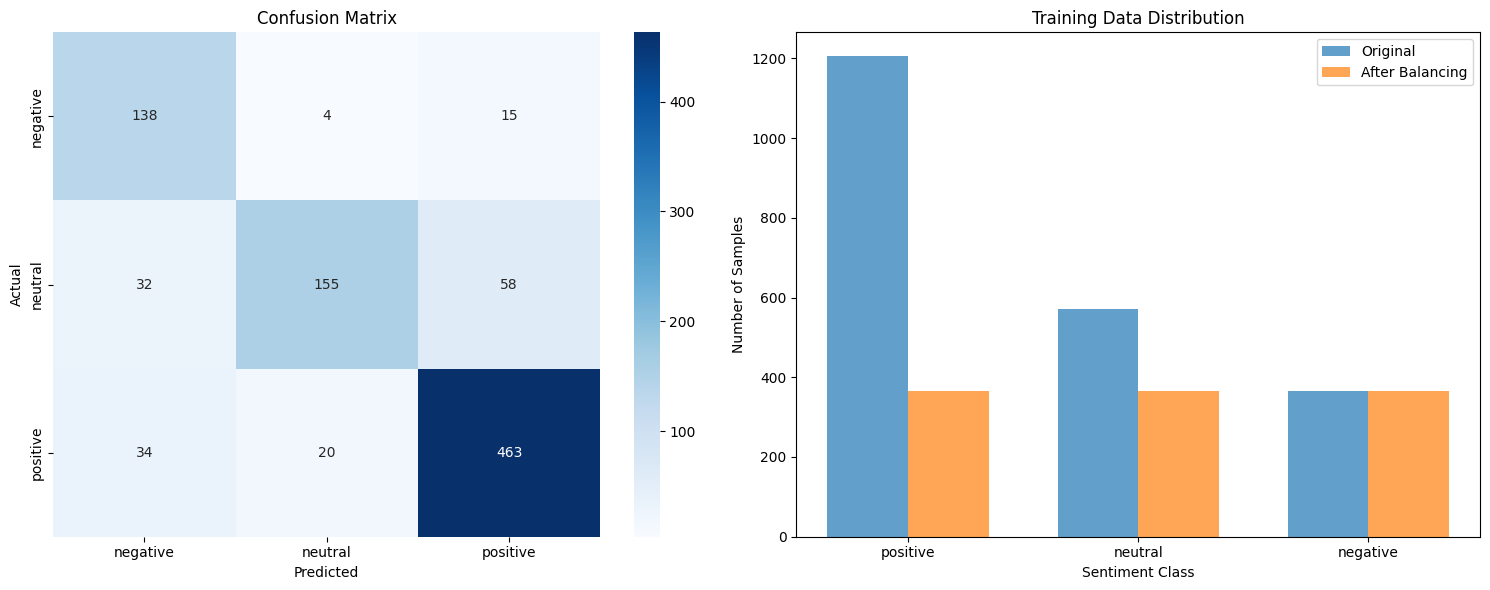

=== GENERATING PERFORMANCE WORD CLOUDS ===


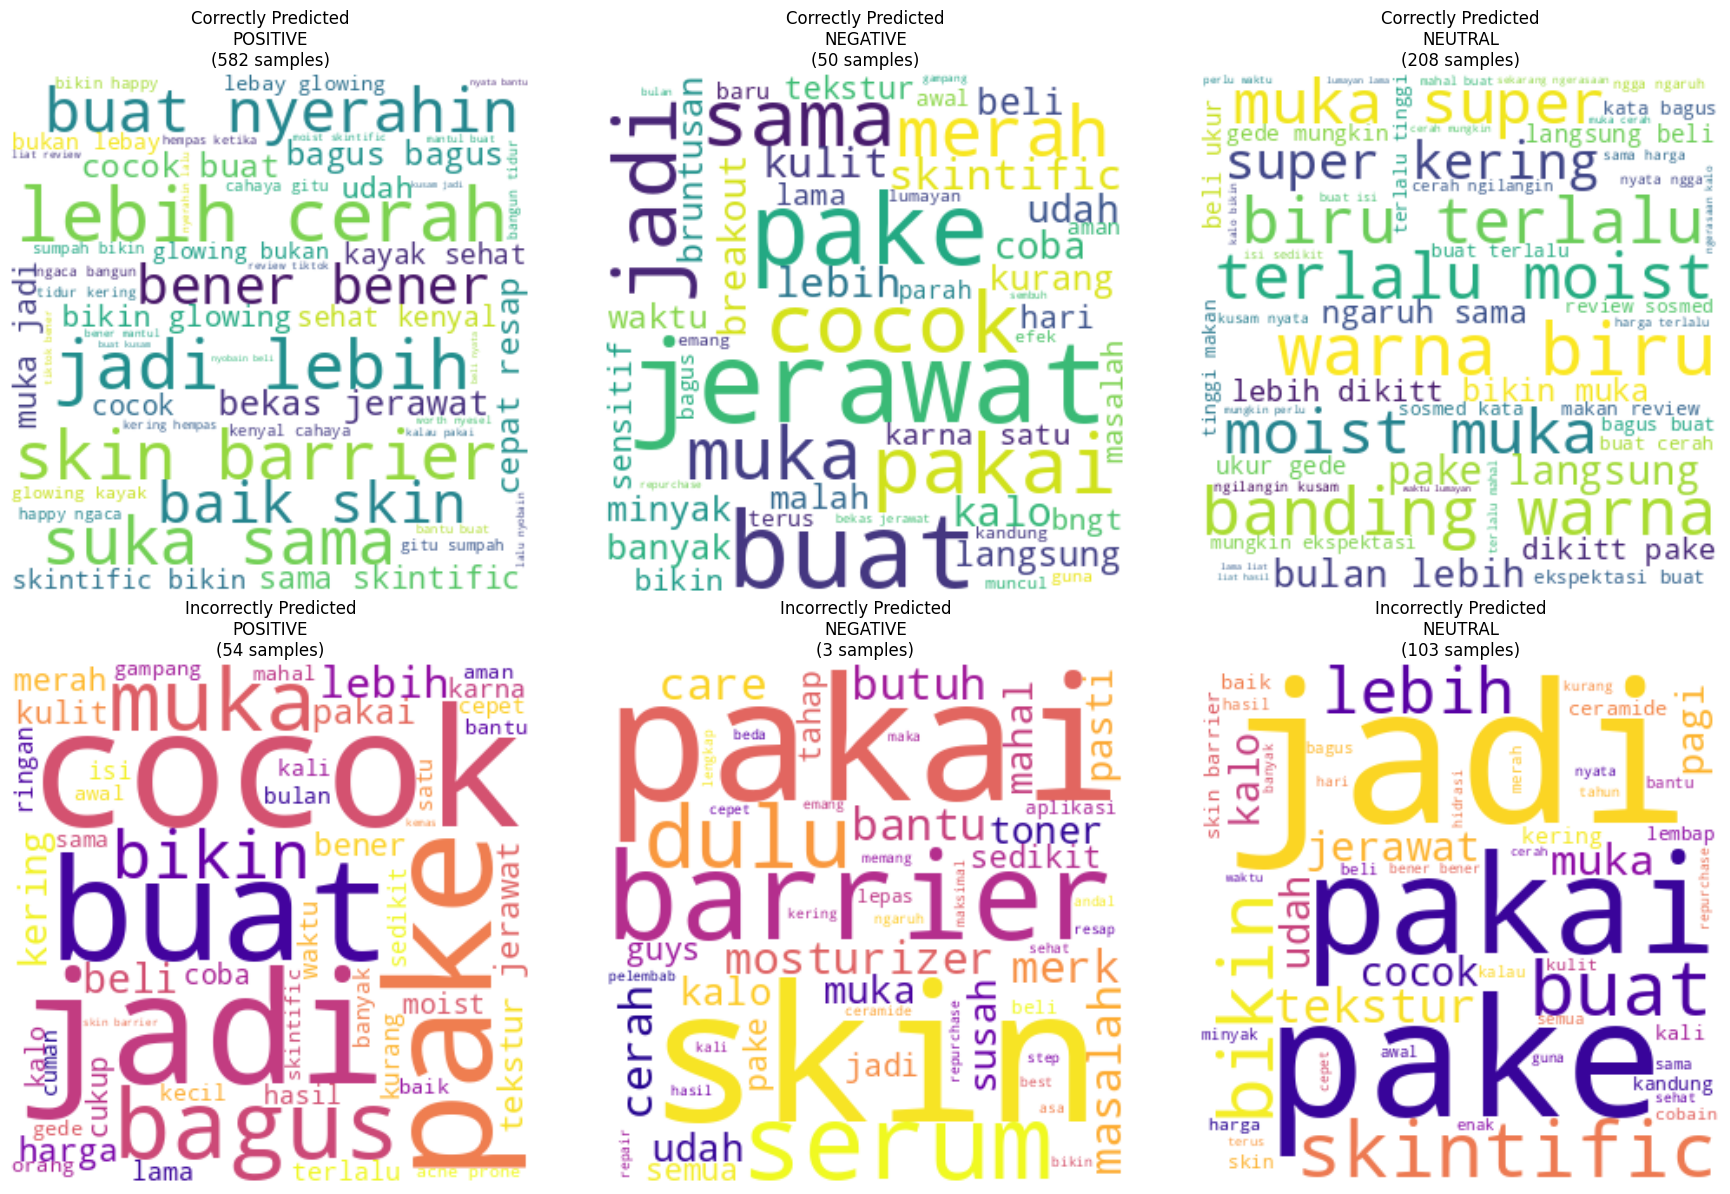


=== TOP FEATURES BY CLASS ===

Top 15 features for negative:
  produk: -5.4481
  jerawat: -5.5376
  breakout: -6.0681
  kecewa: -6.0969
  sangat: -6.1052
  pakai: -6.2059
  lagi: -6.2244
  pake: -6.2280
  beli produk: -6.2299
  Tidak akan: -6.2380
  akan beli: -6.2380
  produk lagi: -6.2380
  Tidak: -6.2380
  akan: -6.2527
  bruntusan: -6.2577

Top 15 features for neutral:
  terlalu: -5.3242
  mungkin: -5.4147
  buat: -5.6776
  muka: -5.8125
  sama: -5.8823
  lebih: -5.9689
  muka super: -5.9750
  warna biru: -5.9800
  banding warna: -5.9834
  terlalu moist: -5.9834
  biru terlalu: -5.9834
  moist muka: -5.9927
  super: -5.9970
  super kering: -6.0016
  banding: -6.0169

Top 15 features for positive:
  buat: -5.7802
  pakai: -5.8195
  cerah: -5.8279
  jadi: -5.8403
  bikin: -5.8428
  bagus: -5.8429
  cocok: -5.8758
  hari: -5.8928
  skin: -5.9179
  muka: -5.9890
  melembabkan: -6.0071
  bener: -6.0085
  suka: -6.0383
  skintific: -6.0546
  pake: -6.0645

=== CLASS BALANCING SUMMARY ==

In [12]:
# MultinomialNB Sentiment Analysis Model with Class Balancing and Enhanced Visualizations
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class SentimentAnalysisModel:
    def __init__(self, vectorizer_type='tfidf', max_features=5000, ngram_range=(1, 2), use_smote=True, use_class_weights=True):
        """
        Initialize the sentiment analysis model with class balancing options

        Parameters:
        - vectorizer_type: 'tfidf' or 'count'
        - max_features: maximum number of features to extract
        - ngram_range: tuple indicating n-gram range (e.g., (1,1) for unigrams, (1,2) for unigrams+bigrams)
        - use_smote: whether to use SMOTE for oversampling minority classes
        - use_class_weights: whether to use class weights for balancing
        """
        self.vectorizer_type = vectorizer_type
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.use_smote = use_smote
        self.use_class_weights = use_class_weights

        # Initialize vectorizer
        if vectorizer_type == 'tfidf':
            self.vectorizer = TfidfVectorizer(
                max_features=max_features,
                ngram_range=ngram_range,
                stop_words=None,  # We already removed stopwords
                lowercase=False,  # Already lowercased
                token_pattern=r'\b\w+\b'
            )
        else:
            self.vectorizer = CountVectorizer(
                max_features=max_features,
                ngram_range=ngram_range,
                stop_words=None,
                lowercase=False,
                token_pattern=r'\b\w+\b'
            )

        # Initialize MultinomialNB (class_weight will be set during training)
        self.model = MultinomialNB()

        # Create pipeline
        self.pipeline = Pipeline([
            ('vectorizer', self.vectorizer),
            ('classifier', self.model)
        ])

        self.is_trained = False
        self.smote = None
        self.class_weights = None

    def prepare_data(self, df, text_column='processed_text', target_column='sentiment'):
        """Prepare data for training"""
        # Filter out empty texts
        df_clean = df.dropna(subset=[text_column, target_column])
        df_clean = df_clean[df_clean[text_column].str.strip() != '']

        X = df_clean[text_column].values
        y = df_clean[target_column].values

        print(f"Prepared {len(X)} samples for training")
        print(f"Original class distribution: {pd.Series(y).value_counts()}")

        return X, y

    # def apply_class_balancing(self, X_train_vectorized, y_train):
    #     """Apply class balancing techniques"""
    #     print("\n=== APPLYING CLASS BALANCING ===")

    #     original_distribution = pd.Series(y_train).value_counts()
    #     print(f"Original training distribution: {original_distribution}")

    #     X_balanced = X_train_vectorized
    #     y_balanced = y_train

    #     # 1. Apply SMOTE if enabled
    #     if self.use_smote:
    #         print("\nApplying SMOTE oversampling...")

    #         # Configure SMOTE - better parameters for 70/30 split
    #         min_class_size = min(original_distribution.values)
    #         k_neighbors = min(5, min_class_size - 1) if min_class_size > 1 else 1

    #         self.smote = SMOTE(
    #             sampling_strategy='auto',  # Balance all classes to match majority class
    #             random_state=42,
    #             k_neighbors=k_neighbors
    #         )

    #         try:
    #             X_balanced, y_balanced = self.smote.fit_resample(X_train_vectorized, y_train)
    #             balanced_distribution = pd.Series(y_balanced).value_counts()
    #             print(f"After SMOTE distribution: {balanced_distribution}")
    #             print(f"Total samples after SMOTE: {len(y_balanced)} (was {len(y_train)})")
    #         except Exception as e:
    #             print(f"SMOTE failed: {e}")
    #             print("Continuing without SMOTE...")
    #             self.use_smote = False

    #     # 2. Calculate class weights if enabled
    #     if self.use_class_weights:
    #         print("\nCalculating class weights...")
    #         unique_classes = np.unique(y_balanced)
    #         class_weights = compute_class_weight(
    #             class_weight='balanced',
    #             classes=unique_classes,
    #             y=y_balanced
    #         )
    #         self.class_weights = dict(zip(unique_classes, class_weights))
    #         print(f"Class weights: {self.class_weights}")

    #         # Update model with class weights
    #         self.model = MultinomialNB()  # Reset model
    #         # Note: MultinomialNB doesn't directly support class_weight parameter
    #         # We'll use sample_weight during training instead

    #     return X_balanced, y_balanced
    def apply_class_balancing(self, X_train_vectorized, y_train):
      """Apply class balancing techniques"""
      print("\n=== APPLYING CLASS BALANCING ===")

      original_distribution = pd.Series(y_train).value_counts()
      print(f"Original training distribution: {original_distribution}")

      X_balanced = X_train_vectorized
      y_balanced = y_train

      # Instead of SMOTE, apply random undersampling
      print("\nApplying random undersampling...")

      # Convert vectorized X back to array for sampling (if needed)
      # Or use indices to sample y and X rows
      from scipy.sparse import vstack

      # Get indices by class
      negative_idx = np.where(y_train == 'negative')[0]
      neutral_idx = np.where(y_train == 'neutral')[0]
      positive_idx = np.where(y_train == 'positive')[0]

      n_negative = len(negative_idx)

      # Downsample neutral and positive to match negative
      rng = np.random.default_rng(seed=42)
      sampled_neutral_idx = rng.choice(neutral_idx, size=n_negative, replace=False)
      sampled_positive_idx = rng.choice(positive_idx, size=n_negative, replace=False)

      combined_idx = np.concatenate([negative_idx, sampled_neutral_idx, sampled_positive_idx])

      # Shuffle indices
      rng.shuffle(combined_idx)

      # Apply to X and y
      X_balanced = X_train_vectorized[combined_idx]
      y_balanced = y_train[combined_idx]

      balanced_distribution = pd.Series(y_balanced).value_counts()
      print(f"After undersampling distribution: {balanced_distribution}")
      print(f"Total samples after undersampling: {len(y_balanced)} (was {len(y_train)})")

      # Calculate class weights if enabled
      if self.use_class_weights:
          print("\nCalculating class weights...")
          unique_classes = np.unique(y_balanced)
          class_weights = compute_class_weight(
              class_weight='balanced',
              classes=unique_classes,
              y=y_balanced
          )
          self.class_weights = dict(zip(unique_classes, class_weights))
          print(f"Class weights: {self.class_weights}")

          # Reset model (MultinomialNB doesn't support class_weight directly)
          self.model = MultinomialNB()

      return X_balanced, y_balanced


    def calculate_sample_weights(self, y):
        """Calculate sample weights based on class weights"""
        if not self.use_class_weights or self.class_weights is None:
            return None

        sample_weights = np.array([self.class_weights[label] for label in y])
        return sample_weights

    def train(self, X, y, test_size=0.3, random_state=42):
        """Train the model with class balancing - using 70/30 split for better SMOTE performance"""
        # Split data with 70/30 split (better for SMOTE with imbalanced data)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        print(f"Training set size: {len(X_train)} (70%)")
        print(f"Test set size: {len(X_test)} (30%)")

        # Vectorize the text data
        print("Vectorizing text data...")
        X_train_vectorized = self.vectorizer.fit_transform(X_train)
        X_test_vectorized = self.vectorizer.transform(X_test)

        # Apply class balancing
        X_train_balanced, y_train_balanced = self.apply_class_balancing(X_train_vectorized, y_train)

        # Calculate sample weights
        sample_weights = self.calculate_sample_weights(y_train_balanced)

        # Train the model
        print("\nTraining MultinomialNB model with balanced data...")
        if sample_weights is not None:
            self.model.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)
            print("Training completed with sample weights!")
        else:
            self.model.fit(X_train_balanced, y_train_balanced)
            print("Training completed!")

        # Update the pipeline with the trained components
        self.pipeline = Pipeline([
            ('vectorizer', self.vectorizer),
            ('classifier', self.model)
        ])

        self.is_trained = True

        # Store data for evaluation (use original test set, not balanced)
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.X_test_vectorized = X_test_vectorized
        self.X_train_vectorized = X_train_vectorized

        # Store balanced training data for analysis
        self.X_train_balanced = X_train_balanced
        self.y_train_balanced = y_train_balanced

        return X_train, X_test, y_train, y_test

    def create_performance_wordclouds(self, df):
        """Create word clouds for correctly and incorrectly predicted samples"""
        if not self.is_trained:
            print("Model not trained. Cannot create performance word clouds.")
            return

        print("=== GENERATING PERFORMANCE WORD CLOUDS ===")

        # Get predictions for the original dataset
        text_col = 'processed_text' if 'processed_text' in df.columns else 'review'
        if text_col not in df.columns:
            print("No suitable text column found.")
            return

        # Get predictions for a sample of the data
        sample_size = min(1000, len(df))  # Limit for performance
        df_sample = df.sample(n=sample_size, random_state=42)

        predictions = self.pipeline.predict(df_sample[text_col])
        correct_mask = predictions == df_sample['sentiment'].values

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Word clouds for each sentiment (correctly predicted)
        sentiments = ['positive', 'negative', 'neutral']
        for i, sentiment in enumerate(sentiments):
            # Correctly predicted
            correct_sentiment = df_sample[correct_mask & (df_sample['sentiment'] == sentiment)]
            if len(correct_sentiment) > 0:
                text = ' '.join(correct_sentiment[text_col].astype(str))
                if len(text.strip()) > 0:
                    wordcloud = WordCloud(width=300, height=300, background_color='white',
                                        colormap='viridis', max_words=50).generate(text)
                    axes[0, i].imshow(wordcloud, interpolation='bilinear')
                    axes[0, i].set_title(f'Correctly Predicted\n{sentiment.upper()}\n({len(correct_sentiment)} samples)')
                else:
                    axes[0, i].text(0.5, 0.5, 'No data', ha='center', va='center')
                    axes[0, i].set_title(f'Correctly Predicted {sentiment.upper()}')
            else:
                axes[0, i].text(0.5, 0.5, 'No data', ha='center', va='center')
                axes[0, i].set_title(f'Correctly Predicted {sentiment.upper()}')
            axes[0, i].axis('off')

            # Incorrectly predicted
            incorrect_sentiment = df_sample[~correct_mask & (df_sample['sentiment'] == sentiment)]
            if len(incorrect_sentiment) > 0:
                text = ' '.join(incorrect_sentiment[text_col].astype(str))
                if len(text.strip()) > 0:
                    wordcloud = WordCloud(width=300, height=300, background_color='white',
                                        colormap='plasma', max_words=50).generate(text)
                    axes[1, i].imshow(wordcloud, interpolation='bilinear')
                    axes[1, i].set_title(f'Incorrectly Predicted\n{sentiment.upper()}\n({len(incorrect_sentiment)} samples)')
                else:
                    axes[1, i].text(0.5, 0.5, 'No data', ha='center', va='center')
                    axes[1, i].set_title(f'Incorrectly Predicted {sentiment.upper()}')
            else:
                axes[1, i].text(0.5, 0.5, 'No data', ha='center', va='center')
                axes[1, i].set_title(f'Incorrectly Predicted {sentiment.upper()}')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    def create_interactive_performance_plots(self):
        """Create interactive plots for model performance analysis"""
        if not self.is_trained:
            print("Model not trained. Cannot create performance plots.")
            return

        print("=== GENERATING INTERACTIVE PERFORMANCE PLOTS ===")

        # Get predictions and probabilities
        y_pred = self.model.predict(self.X_test_vectorized)
        y_pred_proba = self.model.predict_proba(self.X_test_vectorized)
        max_probs = np.max(y_pred_proba, axis=1)

        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Prediction Confidence Distribution',
                'Feature Importance by Class',
                'Class Performance Metrics',
                'Confusion Matrix Heatmap'
            ),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"type": "bar"}, {"secondary_y": False}]]
        )

        # 1. Prediction Confidence Distribution
        correct_predictions = (y_pred == self.y_test)

        fig.add_trace(
            go.Histogram(
                x=max_probs[correct_predictions],
                name='Correct Predictions',
                opacity=0.7,
                marker_color='green',
                nbinsx=30
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Histogram(
                x=max_probs[~correct_predictions],
                name='Incorrect Predictions',
                opacity=0.7,
                marker_color='red',
                nbinsx=30
            ),
            row=1, col=1
        )

        # 2. Feature Importance Heatmap
        feature_names = self.vectorizer.get_feature_names_out()
        feature_log_prob = self.model.feature_log_prob_

        # Get top 15 features for visualization
        n_features = min(15, len(feature_names))
        top_features_idx = np.argsort(np.sum(np.abs(feature_log_prob), axis=0))[-n_features:]

        heatmap_data = feature_log_prob[:, top_features_idx]
        selected_features = feature_names[top_features_idx]

        fig.add_trace(
            go.Heatmap(
                z=heatmap_data,
                x=selected_features,
                y=list(self.model.classes_),
                colorscale='RdYlBu_r',
                showscale=True
            ),
            row=1, col=2
        )

        # 3. Class Performance Metrics
        from sklearn.metrics import classification_report
        class_report = classification_report(self.y_test, y_pred, output_dict=True)

        metrics = ['precision', 'recall', 'f1-score']
        classes = [cls for cls in self.model.classes_ if cls in class_report]

        for metric in metrics:
            values = [class_report[cls][metric] for cls in classes]
            fig.add_trace(
                go.Bar(
                    x=classes,
                    y=values,
                    name=metric.capitalize(),
                    opacity=0.8
                ),
                row=2, col=1
            )

        # 4. Confusion Matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(self.y_test, y_pred)

        fig.add_trace(
            go.Heatmap(
                z=cm,
                x=list(self.model.classes_),
                y=list(self.model.classes_),
                colorscale='Blues',
                text=cm,
                texttemplate="%{text}",
                textfont={"size": 12},
                showscale=True
            ),
            row=2, col=2
        )

        # Update layout
        fig.update_layout(
            title_text="Interactive Model Performance Analysis",
            height=800,
            showlegend=True
        )

        # Update axes
        fig.update_xaxes(title_text="Confidence Score", row=1, col=1)
        fig.update_yaxes(title_text="Frequency", row=1, col=1)

        fig.update_xaxes(title_text="Features", row=1, col=2)
        fig.update_yaxes(title_text="Classes", row=1, col=2)

        fig.update_xaxes(title_text="Classes", row=2, col=1)
        fig.update_yaxes(title_text="Score", row=2, col=1)

        fig.update_xaxes(title_text="Predicted", row=2, col=2)
        fig.update_yaxes(title_text="Actual", row=2, col=2)

        fig.show()

    def evaluate(self):
        """Evaluate the model with enhanced visualizations"""
        if not self.is_trained:
            print("Model is not trained yet!")
            return

        # Predictions on original training set
        y_train_pred = self.model.predict(self.X_train_vectorized)
        train_accuracy = accuracy_score(self.y_train, y_train_pred)

        # Predictions on test set
        y_test_pred = self.model.predict(self.X_test_vectorized)
        test_accuracy = accuracy_score(self.y_test, y_test_pred)

        print("=== MODEL EVALUATION ===")
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        print(f"\n=== CLASSIFICATION REPORT (Test Set) ===")
        print(classification_report(self.y_test, y_test_pred))

        # Detailed per-class analysis
        print(f"\n=== PER-CLASS PERFORMANCE ANALYSIS ===")
        class_report = classification_report(self.y_test, y_test_pred, output_dict=True)

        for class_name in ['negative', 'neutral', 'positive']:
            if class_name in class_report:
                metrics = class_report[class_name]
                support = metrics['support']
                print(f"\n{class_name.upper()}:")
                print(f"  Precision: {metrics['precision']:.4f} (of predicted {class_name}, {metrics['precision']*100:.1f}% were correct)")
                print(f"  Recall: {metrics['recall']:.4f} (detected {metrics['recall']*100:.1f}% of actual {class_name} reviews)")
                print(f"  F1-score: {metrics['f1-score']:.4f}")
                print(f"  Support: {support} samples")

        # Confusion Matrix
        print(f"\n=== CONFUSION MATRIX ===")
        cm = confusion_matrix(self.y_test, y_test_pred)
        print(cm)

        # Create enhanced visualizations
        self.create_interactive_performance_plots()

        # Traditional matplotlib plots for comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=np.unique(self.y_test),
                   yticklabels=np.unique(self.y_test), ax=ax1)
        ax1.set_title('Confusion Matrix')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')

        # Class distribution comparison
        original_dist = pd.Series(self.y_train).value_counts()
        balanced_dist = pd.Series(self.y_train_balanced).value_counts()

        x = range(len(original_dist))
        width = 0.35

        ax2.bar([i - width/2 for i in x], original_dist.values, width, label='Original', alpha=0.7)
        ax2.bar([i + width/2 for i in x], balanced_dist.values, width, label='After Balancing', alpha=0.7)
        ax2.set_xlabel('Sentiment Class')
        ax2.set_ylabel('Number of Samples')
        ax2.set_title('Training Data Distribution')
        ax2.set_xticks(x)
        ax2.set_xticklabels(original_dist.index)
        ax2.legend()

        plt.tight_layout()
        plt.show()

        return {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'classification_report': class_report,
            'confusion_matrix': cm
        }

    def cross_validate(self, X, y, cv=5):
        """Perform cross-validation with balanced data"""
        print(f"Performing {cv}-fold cross-validation with class balancing...")

        # Create a temporary pipeline for cross-validation
        temp_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(
                max_features=self.max_features,
                ngram_range=self.ngram_range,
                stop_words=None,
                lowercase=False,
                token_pattern=r'\b\w+\b'
            )),
            ('classifier', MultinomialNB())
        ])

        cv_scores = cross_val_score(temp_pipeline, X, y, cv=cv, scoring='accuracy')

        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        return cv_scores

    def predict(self, texts):
        """Make predictions on new texts"""
        if not self.is_trained:
            print("Model is not trained yet!")
            return None

        if isinstance(texts, str):
            texts = [texts]

        # Use the pipeline for predictions (ensures consistent preprocessing)
        predictions = self.pipeline.predict(texts)
        return predictions

    def predict_proba(self, texts):
        """Get prediction probabilities"""
        if not self.is_trained:
            print("Model is not trained yet!")
            return None

        if isinstance(texts, str):
            texts = [texts]

        # Use the pipeline for predictions
        probabilities = self.pipeline.predict_proba(texts)
        return probabilities

    def predict_with_details(self, texts):
        """Make predictions with detailed output including probabilities"""
        if not self.is_trained:
            print("Model is not trained yet!")
            return None

        if isinstance(texts, str):
            texts = [texts]

        predictions = self.pipeline.predict(texts)
        probabilities = self.pipeline.predict_proba(texts)
        classes = self.pipeline.classes_

        results = []
        for i, text in enumerate(texts):
            prob_dict = {class_name: prob for class_name, prob in zip(classes, probabilities[i])}
            result = {
                'text': text,
                'predicted_sentiment': predictions[i],
                'probabilities': prob_dict,
                'confidence': max(probabilities[i])
            }
            results.append(result)

        return results

    def plot_sentiment_score_distribution(self, df, text_column='processed_text', target_column='sentiment'):
      """
      Plot sentiment score distribution by true sentiment.
      """
      df = df.copy()
      df['calculated_sentiment_score'] = df[text_column].apply(
          lambda x: sentiment_labeler.calculate_sentiment_score(x)
      )

      import seaborn as sns
      import matplotlib.pyplot as plt

      plt.figure(figsize=(10, 6))
      sns.histplot(data=df, x='calculated_sentiment_score', hue=target_column, bins=50, kde=True)
      plt.title('Sentiment Score Distribution by True Sentiment')
      plt.xlabel('Sentiment Score')
      plt.ylabel('Frequency')
      plt.show()

      return df  # Return df so you can reuse it for threshold tuning

    def tune_negative_threshold(self, df_scored, target_column='sentiment', thresholds=np.arange(-1.0, 0.0, 0.05)):
      """
      Find the best negative threshold balancing precision and recall.
      """
      from sklearn.metrics import precision_score, recall_score, f1_score

      results = []

      for thresh in thresholds:
          y_pred = []
          for score in df_scored['calculated_sentiment_score']:
              if score <= thresh:
                  y_pred.append('negative')
              else:
                  y_pred.append('neutral_or_positive')

          # Create binary labels for evaluation
          y_true_binary = (df_scored[target_column] == 'negative').astype(int)
          y_pred_binary = (np.array(y_pred) == 'negative').astype(int)

          precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
          recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
          f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

          results.append({
              'threshold': thresh,
              'precision': precision,
              'recall': recall,
              'f1': f1
          })

      results_df = pd.DataFrame(results)

      # Plot precision-recall curve
      import matplotlib.pyplot as plt
      plt.figure(figsize=(8, 6))
      plt.plot(results_df['threshold'], results_df['precision'], label='Precision', marker='o')
      plt.plot(results_df['threshold'], results_df['recall'], label='Recall', marker='o')
      plt.plot(results_df['threshold'], results_df['f1'], label='F1-score', marker='o')
      plt.xlabel('Negative Threshold')
      plt.ylabel('Score')
      plt.title('Threshold Tuning for Negative Sentiment')
      plt.legend()
      plt.grid(True)
      plt.show()

      best_row = results_df.loc[results_df['f1'].idxmax()]
      print(f"Best threshold by F1: {best_row['threshold']:.2f}")
      print(f"Precision: {best_row['precision']:.2f}, Recall: {best_row['recall']:.2f}, F1: {best_row['f1']:.2f}")

      return results_df

    def get_feature_importance(self, top_n=15):
        """Get most important features for each class"""
        if not self.is_trained:
            print("Model is not trained yet!")
            return

        feature_names = self.vectorizer.get_feature_names_out()

        # Get feature log probabilities for each class
        feature_log_prob = self.model.feature_log_prob_
        class_labels = self.model.classes_

        print("=== TOP FEATURES BY CLASS ===")

        for i, class_label in enumerate(class_labels):
            print(f"\nTop {top_n} features for {class_label}:")
            # Get indices of top features for this class
            top_indices = feature_log_prob[i].argsort()[-top_n:][::-1]

            for idx in top_indices:
                feature_name = feature_names[idx]
                log_prob = feature_log_prob[i][idx]
                print(f"  {feature_name}: {log_prob:.4f}")

# Check if required packages are available
try:
    import imblearn
    from wordcloud import WordCloud
    import plotly.graph_objects as go
    print("All required packages are available!")
except ImportError as e:
    print(f"Missing package: {e}")
    print("Please install missing packages...")

# Train the model with class balancing if we have data
if len(df) > 0 and 'processed_text' in df.columns and 'sentiment' in df.columns:
    print("Initializing sentiment analysis model with enhanced visualizations...")
    model = SentimentAnalysisModel(
        vectorizer_type='tfidf',
        max_features=3000,
        ngram_range=(1, 2),
        use_smote=True,
        use_class_weights=True
    )

    # Prepare data
    # X, y = model.prepare_data(df)
    X, y = model.prepare_data(df_with_augmented)

    # Cross-validation first
    cv_scores = model.cross_validate(X, y, cv=5)

    # Train the model with 70/30 split
    print("\nTraining the final model with 70/30 split...")
    X_train, X_test, y_train, y_test = model.train(X, y, test_size=0.3)

    # Evaluate the model with enhanced visualizations
    print("\nEvaluating the model with enhanced visualizations...")
    evaluation_results = model.evaluate()

    # Create performance word clouds
    model.create_performance_wordclouds(df)

    # Show feature importance
    print("\n" + "="*50)
    model.get_feature_importance(top_n=15)

    print("\n" + "="*50)
    print("=== CLASS BALANCING SUMMARY ===")
    print(f"SMOTE used: {model.use_smote}")
    print(f"Class weights used: {model.use_class_weights}")
    print(f"Class weights: {model.class_weights}")
    print(f"Original training samples: {len(model.y_train)}")
    print(f"Balanced training samples: {len(model.y_train_balanced)}")

else:
    print("No data available for training!")

In [13]:
# Comprehensive Model Testing and Analysis
def test_model_predictions(model, preprocessor):
    """Test model with sample predictions"""
    if not model.is_trained:
        print("Model is not trained yet!")
        return

    # Sample test texts (in Indonesian and English)
    test_texts = [
        "Produk ini sangat bagus dan membuat kulit saya lembut sekali",
        "Saya tidak suka produk ini karena membuat kulit berminyak",
        "Produk biasa saja, tidak ada perubahan yang signifikan",
        "Amazing product! Highly recommended for sensitive skin",
        "Terrible product, caused breakout on my skin",
        "Moisturizer ini cocok banget untuk kulit kering saya",
        "Gak cocok di kulit saya, malah jadi bruntusan",
        "Harga terjangkau dan kualitas bagus",
        "Overpriced untuk kualitas yang biasa aja",
        "Love this gel moisturizer, very hydrating",
        "Bikin iritasi parah, jangan beli",
        "Worth the hype! Benar-benar worth it",
        "Lumayan sih, tidak jelek tapi juga tidak istimewa"
    ]

    print("=== TESTING MODEL WITH SAMPLE TEXTS ===")
    correct_predictions = 0
    total_predictions = len(test_texts)

    for i, text in enumerate(test_texts, 1):
        # Preprocess text
        processed_text = preprocessor.preprocess(text)

        # Get prediction with details
        results = model.predict_with_details([processed_text])
        result = results[0]

        print(f"\n{i}. Original: {text}")
        print(f"   Processed: {processed_text}")
        print(f"   Predicted: {result['predicted_sentiment']}")
        print(f"   Confidence: {result['confidence']:.4f}")
        print(f"   Probabilities:")
        for sentiment, prob in result['probabilities'].items():
            print(f"     {sentiment}: {prob:.4f}")

    print(f"\n=== SAMPLE TESTING SUMMARY ===")
    print(f"Tested {total_predictions} sample texts")
    print("Review each prediction above to assess model performance")

def analyze_misclassifications(model):
    """Analyze misclassified examples"""
    if not model.is_trained:
        print("Model is not trained yet!")
        return

    # Get predictions using the model's vectorized test data
    y_pred = model.model.predict(model.X_test_vectorized)

    # Find misclassified examples
    misclassified_idx = []
    for i, (true_label, pred_label) in enumerate(zip(model.y_test, y_pred)):
        if true_label != pred_label:
            misclassified_idx.append(i)

    print(f"=== MISCLASSIFICATION ANALYSIS ===")
    print(f"Total misclassified: {len(misclassified_idx)} out of {len(model.y_test)}")
    print(f"Accuracy: {(len(model.y_test) - len(misclassified_idx)) / len(model.y_test):.4f}")

    # Group misclassifications by type
    misclass_by_type = {}
    for idx in misclassified_idx:
        true_label = model.y_test[idx]
        pred_label = y_pred[idx]
        key = f"{true_label} → {pred_label}"
        if key not in misclass_by_type:
            misclass_by_type[key] = []
        misclass_by_type[key].append(idx)

    print(f"\nMisclassification breakdown:")
    for mistake_type, indices in misclass_by_type.items():
        print(f"  {mistake_type}: {len(indices)} cases")

    # Show some examples
    print(f"\nSample misclassified examples (first 8):")
    for i, idx in enumerate(misclassified_idx[:8]):
        text = model.X_test[idx]
        true_label = model.y_test[idx]
        pred_label = y_pred[idx]

        print(f"\n{i+1}. Text: {text[:80]}...")
        print(f"   True: {true_label}, Predicted: {pred_label}")

def detailed_performance_analysis(model):
    """Provide detailed performance analysis"""
    if not model.is_trained:
        print("Model is not trained yet!")
        return

    print("=== DETAILED PERFORMANCE ANALYSIS ===")

    # Get predictions
    y_pred = model.model.predict(model.X_test_vectorized)
    y_pred_proba = model.model.predict_proba(model.X_test_vectorized)

    # Overall accuracy
    accuracy = accuracy_score(model.y_test, y_pred)
    print(f"Overall Test Accuracy: {accuracy:.4f}")

    # Class-wise analysis
    class_report = classification_report(model.y_test, y_pred, output_dict=True)

    print(f"\n=== CLASS-WISE PERFORMANCE ===")
    for class_name in ['negative', 'neutral', 'positive']:
        if class_name in class_report:
            metrics = class_report[class_name]
            print(f"\n{class_name.upper()}:")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            print(f"  F1-score: {metrics['f1-score']:.4f}")
            print(f"  Support: {int(metrics['support'])} samples")

    # Macro and weighted averages
    print(f"\nMACRO AVERAGE:")
    macro = class_report['macro avg']
    print(f"  Precision: {macro['precision']:.4f}")
    print(f"  Recall: {macro['recall']:.4f}")
    print(f"  F1-score: {macro['f1-score']:.4f}")

    print(f"\nWEIGHTED AVERAGE:")
    weighted = class_report['weighted avg']
    print(f"  Precision: {weighted['precision']:.4f}")
    print(f"  Recall: {weighted['recall']:.4f}")
    print(f"  F1-score: {weighted['f1-score']:.4f}")

    # Confidence analysis
    print(f"\n=== CONFIDENCE ANALYSIS ===")
    max_probabilities = np.max(y_pred_proba, axis=1)
    print(f"Average confidence: {np.mean(max_probabilities):.4f}")
    print(f"Confidence std: {np.std(max_probabilities):.4f}")
    print(f"Min confidence: {np.min(max_probabilities):.4f}")
    print(f"Max confidence: {np.max(max_probabilities):.4f}")

    # High vs low confidence predictions
    high_conf_threshold = 0.7
    low_conf_threshold = 0.5

    high_conf_mask = max_probabilities >= high_conf_threshold
    low_conf_mask = max_probabilities <= low_conf_threshold

    if np.sum(high_conf_mask) > 0:
        high_conf_accuracy = accuracy_score(model.y_test[high_conf_mask], y_pred[high_conf_mask])
        print(f"\nHigh confidence predictions (≥{high_conf_threshold}): {np.sum(high_conf_mask)} samples")
        print(f"High confidence accuracy: {high_conf_accuracy:.4f}")

    if np.sum(low_conf_mask) > 0:
        low_conf_accuracy = accuracy_score(model.y_test[low_conf_mask], y_pred[low_conf_mask])
        print(f"Low confidence predictions (≤{low_conf_threshold}): {np.sum(low_conf_mask)} samples")
        print(f"Low confidence accuracy: {low_conf_accuracy:.4f}")

def class_balance_impact_analysis(model):
    """Analyze the impact of class balancing"""
    if not model.is_trained:
        print("Model is not trained yet!")
        return

    print("=== CLASS BALANCING IMPACT ANALYSIS ===")

    # Original vs balanced distribution
    original_dist = pd.Series(model.y_train).value_counts()
    balanced_dist = pd.Series(model.y_train_balanced).value_counts()

    print(f"\nOriginal training distribution:")
    for sentiment, count in original_dist.items():
        percentage = (count / len(model.y_train)) * 100
        print(f"  {sentiment}: {count} ({percentage:.1f}%)")

    print(f"\nAfter SMOTE balancing:")
    for sentiment, count in balanced_dist.items():
        percentage = (count / len(model.y_train_balanced)) * 100
        print(f"  {sentiment}: {count} ({percentage:.1f}%)")

    # Calculate improvement ratios
    print(f"\nClass balancing effect:")
    for sentiment in original_dist.index:
        original_count = original_dist[sentiment]
        balanced_count = balanced_dist[sentiment]
        ratio = balanced_count / original_count
        print(f"  {sentiment}: {ratio:.2f}x increase")

    # Test set distribution (should remain original)
    test_dist = pd.Series(model.y_test).value_counts()
    print(f"\nTest set distribution (natural):")
    for sentiment, count in test_dist.items():
        percentage = (count / len(model.y_test)) * 100
        print(f"  {sentiment}: {count} ({percentage:.1f}%)")

def hyperparameter_tuning(X, y):
    """Perform hyperparameter tuning for the model"""
    print("=== HYPERPARAMETER TUNING ===")
    print("Note: This may take several minutes...")

    # Define parameter grid
    param_grid = {
        'vectorizer__max_features': [1000, 3000, 5000],
        'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'classifier__alpha': [0.1, 0.5, 1.0, 2.0]
    }

    # Create pipeline for grid search
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words=None, lowercase=False)),
        ('classifier', MultinomialNB())
    ])

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,  # Use 3-fold CV for faster execution
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    print("Starting grid search...")
    grid_search.fit(X, y)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Train model with best parameters
    best_model = grid_search.best_estimator_

    return best_model, grid_search.best_params_

# Run comprehensive testing if model is available
if 'model' in locals() and model.is_trained:
    print("Running comprehensive model testing and analysis...")

    # 1. Test with sample predictions
    test_model_predictions(model, preprocessor)

    # 2. Detailed performance analysis
    print("\n" + "="*60)
    detailed_performance_analysis(model)

    # 3. Analyze misclassifications
    print("\n" + "="*60)
    analyze_misclassifications(model)

    # 4. Class balancing impact analysis
    print("\n" + "="*60)
    class_balance_impact_analysis(model)

    # 5. Optional hyperparameter tuning (commented out to save time)
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING")
    print("Hyperparameter tuning is available but commented out to save time.")
    print("Uncomment the lines below to run it:")
    print("# best_model, best_params = hyperparameter_tuning(X, y)")
    print("# print(f'Best model accuracy: {best_model.score(model.X_test_vectorized, model.y_test):.4f}')")

    # Uncomment below to run hyperparameter tuning
    # best_model, best_params = hyperparameter_tuning(X, y)
    # test_accuracy = best_model.score(model.X_test_vectorized, model.y_test)
    # print(f"Best model test accuracy: {test_accuracy:.4f}")

    print(f"\n" + "="*60)
    print("=== TESTING COMPLETE ===")
    print("The model has been comprehensively tested with:")
    print("✓ Sample text predictions")
    print("✓ Detailed performance metrics")
    print("✓ Misclassification analysis")
    print("✓ Class balancing impact assessment")
    print("○ Hyperparameter tuning (optional)")

else:
    print("Model not available. Please run the training cell first.")

Running comprehensive model testing and analysis...
=== TESTING MODEL WITH SAMPLE TEXTS ===

1. Original: Produk ini sangat bagus dan membuat kulit saya lembut sekali
   Processed: bagus buat lembut
   Predicted: positive
   Confidence: 0.4143
   Probabilities:
     negative: 0.2158
     neutral: 0.3699
     positive: 0.4143

2. Original: Saya tidak suka produk ini karena membuat kulit berminyak
   Processed: tidak suka buat minyak
   Predicted: negative
   Confidence: 0.5124
   Probabilities:
     negative: 0.5124
     neutral: 0.2353
     positive: 0.2523

3. Original: Produk biasa saja, tidak ada perubahan yang signifikan
   Processed: biasa tidak ubah signifikan
   Predicted: negative
   Confidence: 0.4243
   Probabilities:
     negative: 0.4243
     neutral: 0.3080
     positive: 0.2678

4. Original: Amazing product! Highly recommended for sensitive skin
   Processed: amazing product highly recommended sensitive skin
   Predicted: positive
   Confidence: 0.4942
   Probabilities:
 

In [14]:
# Model Saving and Final Analysis
import pickle
import json
from datetime import datetime

def save_model_and_results(model, evaluation_results, cv_scores, filename_prefix='sentiment_model'):
    """Save the trained model and results"""
    if not model.is_trained:
        print("Model is not trained yet!")
        return

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save the model
    model_filename = f"{filename_prefix}_{timestamp}.pkl"
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved as: {model_filename}")

    # Save evaluation results
    results = {
        'timestamp': timestamp,
        'model_type': 'MultinomialNB',
        'vectorizer_type': model.vectorizer_type,
        'max_features': model.max_features,
        'ngram_range': model.ngram_range,
        'train_accuracy': evaluation_results['train_accuracy'],
        'test_accuracy': evaluation_results['test_accuracy'],
        'classification_report': evaluation_results['classification_report'],
        'cv_scores': cv_scores.tolist(),
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    results_filename = f"evaluation_results_{timestamp}.json"
    with open(results_filename, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print(f"Evaluation results saved as: {results_filename}")

    return model_filename, results_filename

def load_model(filename):
    """Load a saved model"""
    try:
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from: {filename}")
        return model
    except FileNotFoundError:
        print(f"Model file {filename} not found!")
        return None

def create_sentiment_analysis_report(df, model, evaluation_results, cv_scores):
    """Create a comprehensive analysis report"""
    report = []
    report.append("="*60)
    report.append("SENTIMENT ANALYSIS REPORT")
    report.append("="*60)
    report.append(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("")

    # Dataset Statistics
    report.append("DATASET STATISTICS:")
    report.append(f"- Total reviews: {len(df)}")
    report.append(f"- Unique products: {df['product'].nunique() if 'product' in df.columns else 'N/A'}")

    if 'sentiment' in df.columns:
        sentiment_dist = df['sentiment'].value_counts()
        report.append("- Sentiment distribution:")
        for sentiment, count in sentiment_dist.items():
            percentage = (count / len(df)) * 100
            report.append(f"  {sentiment}: {count} ({percentage:.1f}%)")

    report.append("")

    # Model Configuration
    report.append("MODEL CONFIGURATION:")
    report.append(f"- Algorithm: MultinomialNB")
    report.append(f"- Vectorizer: {model.vectorizer_type.upper()}")
    report.append(f"- Max features: {model.max_features}")
    report.append(f"- N-gram range: {model.ngram_range}")
    report.append("")

    # Model Performance
    report.append("MODEL PERFORMANCE:")
    report.append(f"- Training accuracy: {evaluation_results['train_accuracy']:.4f}")
    report.append(f"- Test accuracy: {evaluation_results['test_accuracy']:.4f}")
    report.append(f"- Cross-validation mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    report.append("")

    # Metric Definitions
    report.append("CLASSIFICATION METRICS DEFINITIONS:")
    report.append("- Precision: Of all instances predicted as positive for a class, how many were actually positive?")
    report.append("  Formula: True Positives / (True Positives + False Positives)")
    report.append("  Higher precision means fewer false positive errors.")
    report.append("")
    report.append("- Recall (Sensitivity): Of all actual positive instances for a class, how many were correctly identified?")
    report.append("  Formula: True Positives / (True Positives + False Negatives)")
    report.append("  Higher recall means fewer false negative errors.")
    report.append("")
    report.append("- F1-Score: Harmonic mean of precision and recall, balancing both metrics.")
    report.append("  Formula: 2 * (Precision * Recall) / (Precision + Recall)")
    report.append("  F1-score is useful when you need a balance between precision and recall.")
    report.append("")
    report.append("- Support: The number of actual occurrences of each class in the test dataset.")
    report.append("  This shows how many samples of each class were used for evaluation.")
    report.append("")

    # Classification Report
    report.append("DETAILED CLASSIFICATION METRICS:")
    class_report = evaluation_results['classification_report']
    for class_name in ['negative', 'neutral', 'positive']:
        if class_name in class_report:
            metrics = class_report[class_name]
            report.append(f"{class_name.upper()}:")
            report.append(f"  Precision: {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
            report.append(f"  Recall: {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
            report.append(f"  F1-score: {metrics['f1-score']:.4f} ({metrics['f1-score']*100:.2f}%)")
            report.append(f"  Support: {metrics['support']} samples")
            report.append("")

    # Overall metrics
    if 'macro avg' in class_report:
        macro_avg = class_report['macro avg']
        report.append("MACRO AVERAGE (unweighted mean across all classes):")
        report.append(f"  Precision: {macro_avg['precision']:.4f} ({macro_avg['precision']*100:.2f}%)")
        report.append(f"  Recall: {macro_avg['recall']:.4f} ({macro_avg['recall']*100:.2f}%)")
        report.append(f"  F1-score: {macro_avg['f1-score']:.4f} ({macro_avg['f1-score']*100:.2f}%)")
        report.append("")

    if 'weighted avg' in class_report:
        weighted_avg = class_report['weighted avg']
        report.append("WEIGHTED AVERAGE (weighted by support for each class):")
        report.append(f"  Precision: {weighted_avg['precision']:.4f} ({weighted_avg['precision']*100:.2f}%)")
        report.append(f"  Recall: {weighted_avg['recall']:.4f} ({weighted_avg['recall']*100:.2f}%)")
        report.append(f"  F1-score: {weighted_avg['f1-score']:.4f} ({weighted_avg['f1-score']*100:.2f}%)")
        report.append("")

    # Recommendations
    report.append("RECOMMENDATIONS:")
    test_acc = evaluation_results['test_accuracy']
    if test_acc >= 0.8:
        report.append("- Model performance is excellent (>80% accuracy)")
    elif test_acc >= 0.7:
        report.append("- Model performance is good (70-80% accuracy)")
    elif test_acc >= 0.6:
        report.append("- Model performance is acceptable (60-70% accuracy)")
        report.append("- Consider collecting more training data")
        report.append("- Try different preprocessing techniques")
    else:
        report.append("- Model performance needs improvement (<60% accuracy)")
        report.append("- Collect more diverse training data")
        report.append("- Review preprocessing and feature extraction")
        report.append("- Consider different algorithms or ensemble methods")

    report.append("")
    report.append("="*60)

    # Save report
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_filename = f"sentiment_analysis_report_{timestamp}.txt"
    with open(report_filename, 'w', encoding='utf-8') as f:
        f.write('\n'.join(report))

    print(f"Analysis report saved as: {report_filename}")

    # Print report
    print('\n'.join(report))

    return report_filename

# Execute final analysis if model is available
if 'model' in locals() and 'evaluation_results' in locals() and 'cv_scores' in locals():
    print("Creating final analysis and saving results...")

    # Save model and results
    model_file, results_file = save_model_and_results(model, evaluation_results, cv_scores)

    # Create comprehensive report
    report_file = create_sentiment_analysis_report(df, model, evaluation_results, cv_scores)

    print(f"\n=== FILES CREATED ===")
    print(f"1. Model file: {model_file}")
    print(f"2. Results file: {results_file}")
    print(f"3. Analysis report: {report_file}")

    print(f"\n=== NEXT STEPS ===")
    print("1. Review the analysis report for insights")
    print("2. Use the saved model for future predictions")
    print("3. Consider collecting more data if accuracy is low")
    print("4. Experiment with different preprocessing techniques")
    print("5. Try hyperparameter tuning for better performance")

else:
    print("Please run all previous cells to train the model first.")

Creating final analysis and saving results...
Model saved as: sentiment_model_20250706_004314.pkl
Evaluation results saved as: evaluation_results_20250706_004314.json
Analysis report saved as: sentiment_analysis_report_20250706_004314.txt
SENTIMENT ANALYSIS REPORT
Generated on: 2025-07-06 00:43:14

DATASET STATISTICS:
- Total reviews: 2671
- Unique products: 2
- Sentiment distribution:
  positive: 1722 (64.5%)
  neutral: 818 (30.6%)
  negative: 131 (4.9%)

MODEL CONFIGURATION:
- Algorithm: MultinomialNB
- Vectorizer: TFIDF
- Max features: 3000
- N-gram range: (1, 2)

MODEL PERFORMANCE:
- Training accuracy: 0.8739
- Test accuracy: 0.8226
- Cross-validation mean: 0.7945 (+/- 0.2277)

CLASSIFICATION METRICS DEFINITIONS:
- Precision: Of all instances predicted as positive for a class, how many were actually positive?
  Formula: True Positives / (True Positives + False Positives)
  Higher precision means fewer false positive errors.

- Recall (Sensitivity): Of all actual positive instances 


Plotting sentiment score distribution...


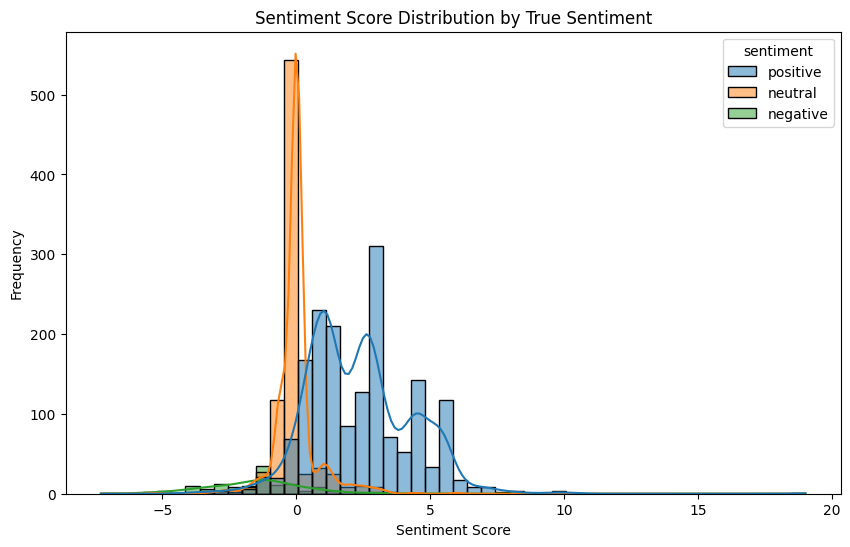


Tuning negative sentiment threshold...


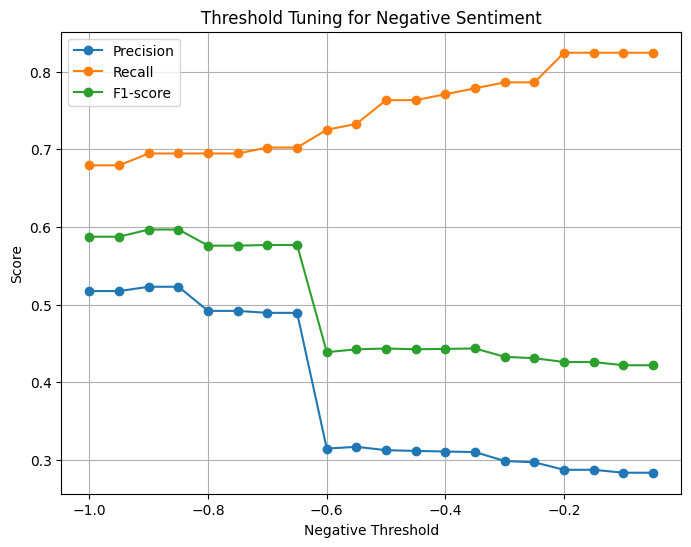

Best threshold by F1: -0.90
Precision: 0.52, Recall: 0.69, F1: 0.60


In [15]:
# Assuming df is your dataset with processed_text and sentiment
print("\nPlotting sentiment score distribution...")
df_scored = model.plot_sentiment_score_distribution(df)

print("\nTuning negative sentiment threshold...")
results_df = model.tune_negative_threshold(df_scored)

